In [1]:
import gzip


In [2]:

import pandas as pd
import numpy as np

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
from textblob import TextBlob, Word
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet, words

from sklearn.feature_extraction import text
import pickle
import scipy.sparse
import re
import string


from langdetect import detect


from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD, NMF,LatentDirichletAllocation
from sklearn.cluster import KMeans

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from gensim.models.coherencemodel import CoherenceModel
from gensim import models, utils
from gensim.corpora.dictionary import Dictionary

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
with gzip.open('./METIS/reviewsNY.csv.gz') as f:

    reviews_NY = pd.read_csv(f)

reviews_NY.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [4]:
with gzip.open('./METIS/listingsNY.csv.gz') as f:

    listings_NY = pd.read_csv(f)

In [5]:
listings_NY.review_scores_rating.describe()

count    27627.000000
mean         4.578315
std          0.854467
min          0.000000
25%          4.570000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

In [6]:
listings_sml = listings_NY[listings_NY.review_scores_rating < 4]

In [7]:
listings_sml.drop([ 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],axis = 1, inplace =True)

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
reviews_NY.shape

(848725, 6)

In [9]:
reviews_NY.listing_id.nunique()

27627

In [10]:
reviews_NY.reviewer_id.nunique()

741329

In [13]:
reviews_NY.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      6
comments         824
dtype: int64

In [8]:
reviews_NY.dropna(subset=['comments'], inplace =True)

In [ ]:
# Sample subset of review data set 
reviews_sml = reviews_NY.sample(n=50000, random_state = 42)



In [ ]:
def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False



In [51]:
reviews_sml = reviews_sml[reviews_sml['comments'].apply(detect_en)]

In [526]:
merged = listings_sml.merge(reviews_sml, how='left', left_on='id', right_on='listing_id')
merged.head()

,id_x,listing_id,id_y,date,reviewer_id,reviewer_name,comments,comments_cln,comments_lmn
0,36442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,249618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,263232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [522]:
listings_sml.head(1)

,id
78,36442


In [525]:
merged[(merged['id_x']==36442)]

,id_x,listing_id,id_y,date,reviewer_id,reviewer_name,comments,comments_cln,comments_lmn


In [54]:
# create a column for whether a review is an automated posting (yes, no)
def autopost(x):
    if 'an automated posting' in x:
        return False
    else:
        return True
reviews_sml  = reviews_sml[reviews_sml['comments'].apply(autopost)]

In [53]:
# Remove numbers, capital letters, punctuation, extra blank spaces, etc.

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_non_english_chars = lambda x: re.sub('[^a-zA-Z0-9_]', ' ', x)
extra_space = lambda x: re.sub('!{2,}', ' ', x)

reviews_sml["comments_cln"] = reviews_sml["comments"].map(alphanumeric).map(punc_lower).map(remove_non_english_chars).map(extra_space)

In [86]:
# Pre-processing & Lemmatizing text #

def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

reviews_sml['comments_lmn'] = reviews_sml['comments_cln'].apply(lambda x: lemmatize_with_postag(x))#lemmatization

In [88]:
reviews_sml.drop('comments_leman', axis =1, inplace = True)

In [89]:
reviews_sml.shape

(43947, 8)

In [90]:
#Store data in pickle object to use for modeling
reviews_sml.to_pickle('reviews_Eng.pickle')

In [49]:
df= pd.read_pickle('reviews_Eng.pickle')
df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_cln,comments_lmn
690518,31267560,735699981,2021-03-01,387277763,Jasmine,Lakshmee was amazing ! Very nice for one night...,lakshmee was amazing very nice for one night...,lakshmee be amaze very nice for one night she ...
620226,25626152,282142661,2018-06-26,91671544,Marvin,Hyas place was awesome! She was very helpful ...,hyas place was awesome she was very helpful ...,hyas place be awesome she be very helpful and ...
560286,21786958,272487388,2018-06-03,92399364,Kristina,Sharon is super nice. the whole stay was great...,sharon is super nice the whole stay was great...,sharon be super nice the whole stay be great w...


In [170]:
stopwords_addition = ["airbnb", "bnb", "a", "aa", "aaa", "br", "york", "need", "make",
                      "good", "great", "perfect", "br", "amazing", "recommend", "place", "like", "nice",
                    "room", "stay", "overall", "really", "check",  "unit", "did", "didn", "day",
                    "night", "just", "super", "love",  "days", "lot","awesome", "ny",
                    "definitely", "wonderful", "reservation",  "s", "locate","nyc", "location",'thanks','thank', "brooklyn", 
                      "manhattan", "away", "station", "time", "come","thoroughly","ve",'t','feel','want','don','say','wasn','min',
                     'bit','little','let','issue','big']
custom_stopwords = text.ENGLISH_STOP_WORDS.union(stopwords_addition)

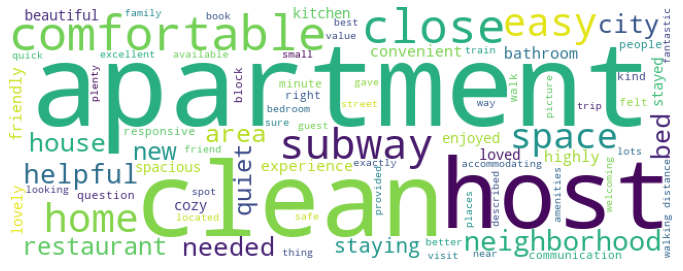

In [11]:

words = " ".join(str(w) for w in df.comments_cln)
plt.subplots(figsize=(12,6))
wordcloud = WordCloud(stopwords =custom_stopwords, background_color='white',width=650,height=250,max_words=80).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('name.png',bbox_inches = 'tight')
plt.show()


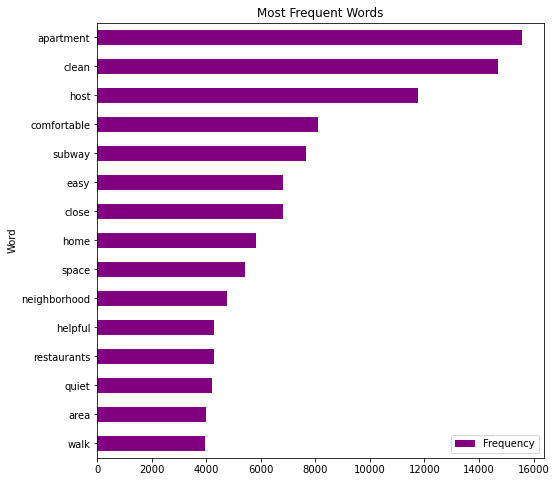

In [320]:
top_N = 15

words = nltk.tokenize.word_tokenize(" ".join(str(w) for w in df.comments_cln))
    #df.comments_cln.str.cat(sep = ' '))

words1 = [word for word in words if word not in custom_stopwords]
    
word_dist = nltk.FreqDist(words1)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
rslt.sort_values(by='Frequency').plot.barh(x='Word',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")
plt.savefig('frequent_hist.png',bbox_inches = 'tight')
plt.show()

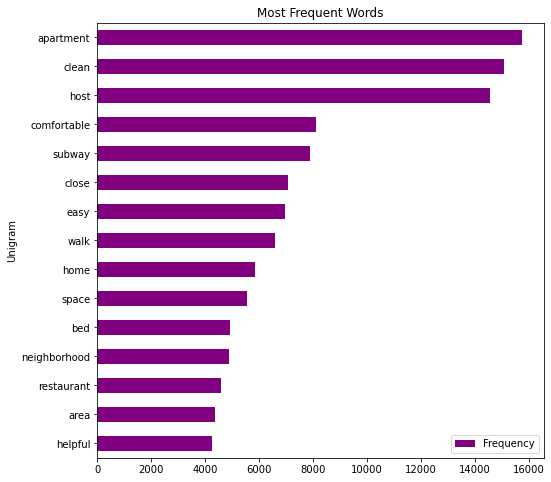

In [321]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['comments_lmn'], 15)
df2 = pd.DataFrame(common_words, columns = ['Unigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df2.sort_values(by='Frequency').plot.barh(x='Unigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")
plt.savefig('unigram_hist.png',bbox_inches = 'tight')
plt.show()

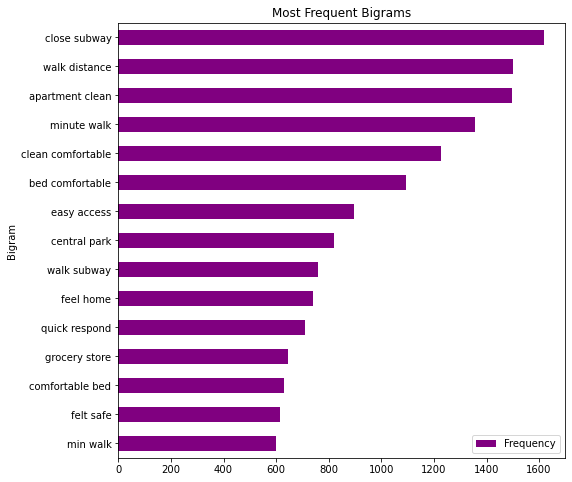

In [322]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['comments_lmn'], 15)
df3 = pd.DataFrame(common_words, columns = ['Bigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df3.sort_values(by='Frequency').plot.barh(x='Bigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Bigrams")
plt.savefig('bigram_hist.png',bbox_inches = 'tight')
plt.show()

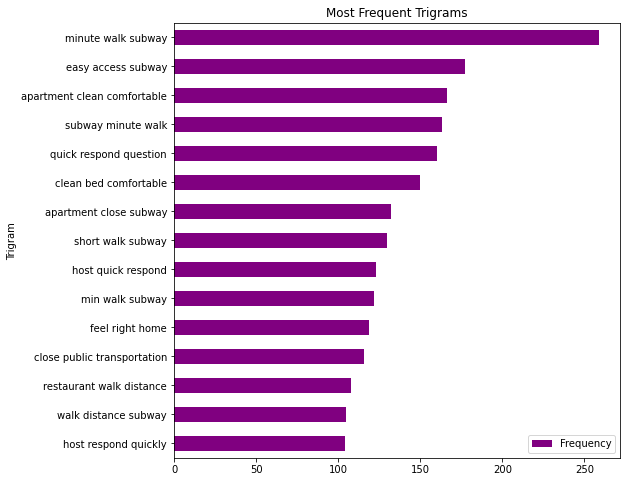

In [323]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['comments_lmn'], 15)
df4 = pd.DataFrame(common_words, columns = ['Trigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df4.sort_values(by='Frequency').plot.barh(x='Trigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Trigrams")
plt.savefig('trigram_hist.png',bbox_inches = 'tight')
plt.show()

In [12]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=10):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [13]:
docs = df["comments_lmn"]

# CountVectorizer / LatentDirichletAllocation

In [350]:
preprocessor = None
vectorizer3 = CountVectorizer(stop_words = custom_stopwords,
                              ngram_range=(1,2),
                                max_df = 0.8, 
                                min_df = 10,
                             max_features = 1000)
topic_modeler6 = LatentDirichletAllocation(n_components=20, random_state=10)

make_topics(docs, preprocessor, vectorizer3, topic_modeler6);

Topic 0:
 MINUTE, WALK, TRAIN, SUBWAY, MINUTE WALK, SHORT, WALK SUBWAY, SHORT WALK, CLOSE, RIDE 

Topic 1:
 HOME, FELT, SAFE, LOVELY, NEIGHBORHOOD, BEAUTIFUL, FELT SAFE, FELT HOME, WELCOME, COMFORTABLE 

Topic 2:
 HOST, WELCOME, EXCELLENT, EXPLORE, HOSPITALITY, FLIGHT, WARM, COOL, CITY, EXCELLENT HOST 

Topic 3:
 STREET, PARKING, COMFORTABLE, SPOT, SURE, PARK, CAR, YEAR, OLD, RIGHT 

Topic 4:
 WALK, DISTANCE, WALK DISTANCE, EAST, VILLAGE, APARTMENT, RESTAURANT, NICELY, ENJOY, DECORATE 

Topic 5:
 KITCHEN, APARTMENT, BEDROOM, SPACE, AREA, EQUIP, LIVING, COOK, LARGE, BATHROOM 

Topic 6:
 EXACTLY, PRICE, VALUE, PICTURE, LOOK, HOST, ACCOMMODATE, CLEAN, FLAT, HOTEL 

Topic 7:
 CLOSE, SUBWAY, HELPFUL, CLOSE SUBWAY, FRIENDLY, TRANSPORTATION, HOST, PUBLIC, CLEAN, EASY 

Topic 8:
 EASY, SPACE, COMMUNICATE, SMALL, CLEAN, EASY COMMUNICATE, LIGHT, PLENTY, CONVENIENT, DESCRIPTION 

Topic 9:
 BED, BATHROOM, COMFORTABLE, CLEAN, COMFY, BED COMFORTABLE, PRIVATE, SHOWER, COMFORTABLE BED, SLEEP 

Topic 1

In [17]:
preprocessor = None
vectorizer3 = CountVectorizer(stop_words = custom_stopwords,
                              ngram_range=(1,2),
                                max_df = 0.7, 
                                min_df = 10,max_features = 1000)
topic_modeler7 = LatentDirichletAllocation(n_components=10, random_state=10)

make_topics(docs, preprocessor, vectorizer3, topic_modeler7);

Topic 0:
 SUBWAY, WALK, MINUTE, TRAIN, STORE, MINUTE WALK, APARTMENT, CLOSE, NEAR, CLEAN 

Topic 1:
 HOME, FELT, SAFE, BEST, NEW, HOST, NEIGHBORHOOD, EXPERIENCE, LOVELY, BEAUTIFUL 

Topic 2:
 HOST, CLEAN, APARTMENT, COMFORTABLE, RESPONSIVE, HIGHLY, EXCELLENT, HELPFUL, FRIENDLY, FANTASTIC 

Topic 3:
 HOUSE, LOOK, HOST, ASK, LEAVE, DOOR, NEW, STREET, BOOK, THING 

Topic 4:
 RESTAURANT, WALK, APARTMENT, DISTANCE, SHOP, BAR, PARK, WALK DISTANCE, CLOSE, SUBWAY 

Topic 5:
 APARTMENT, SPACIOUS, QUESTION, KITCHEN, BEAUTIFUL, CLEAN, COMFORTABLE, ANSWER, PARK, AVAILABLE 

Topic 6:
 CLEAN, SPACE, QUIET, HOST, EXACTLY, VALUE, AMAZE, PRICE, LOOK, ACCOMMODATE 

Topic 7:
 CLOSE, QUICK, SUBWAY, HOST, CLEAN, RESPOND, CLOSE SUBWAY, HELPFUL, FRIENDLY, COZY 

Topic 8:
 EASY, APARTMENT, COMMUNICATION, CLEAN, ACCESS, COMMUNICATE, EASY ACCESS, HOST, VILLAGE, EASY COMMUNICATE 

Topic 9:
 BED, BATHROOM, CLEAN, KITCHEN, COMFORTABLE, BEDROOM, SMALL, SLEEP, SHOWER, COMFY 



In [18]:
pyLDAvis.sklearn.prepare(LatentDirichletAllocation(n_components=10, random_state=10).fit(vectorizer3.fit_transform(docs)), vectorizer3.fit_transform(docs), vectorizer3, mds = 'mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.175049  0.252897       1        1  15.009659
1      0.095526 -0.033293       2        1  12.052212
3     -0.012430  0.243297       3        1  11.825376
0     -0.037374 -0.255784       4        1  10.774847
4     -0.249296 -0.052371       5        1   9.938287
2      0.264237  0.014101       6        1   9.258119
5     -0.093035  0.058798       7        1   8.729052
6     -0.165040 -0.190247       8        1   7.572042
7      0.207709 -0.229790       9        1   7.456583
8      0.164751  0.192391      10        1   7.383822, topic_info=           Term          Freq         Total Category  logprob  loglift
446        home   5832.000000   5832.000000  Default  30.0000  30.0000
455        host  14415.000000  14415.000000  Default  29.0000  29.0000
38    apartment  15747.000000  15747.000000  Default  28.0000  28.0000
310        easy   6898.000000   6898.000000  Default  27.0000  27.0000
197       close   6997.000000   6997.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
824       space    419.471649   5515.841749  Topic10  -4.6870   0.0295
333     exactly    316.418589   1724.586053  Topic10  -4.9689   0.9102
342  experience    318.492217   3473.355626  Topic10  -4.9624   0.2166
989        work    283.942319   2138.248079  Topic10  -5.0772   0.5869
64       arrive    274.374179   1472.751033  Topic10  -5.1115   0.9255

[575 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         1  0.017435  absolutely
2         2  0.363852  absolutely
2         3  0.054578  absolutely
2         4  0.042449  absolutely
2         5  0.065948  absolutely
...     ...       ...         ...
997       2  0.183106        year
997       3  0.773842        year
997       5  0.002180        year
997       7  0.034877        year
998       3  0.995915    year old

[2194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 4, 1, 5, 3, 6, 7, 8, 9])

In [19]:
preprocessor = None
vectorizer3 = CountVectorizer(stop_words = custom_stopwords,
                              ngram_range=(1,2),
                                max_df = 0.7, 
                                min_df = 10,max_features = 1000)
topic_modeler8 = LatentDirichletAllocation(n_components=12, random_state=10)

make_topics(docs, preprocessor, vectorizer3, topic_modeler8);

Topic 0:
 WALK, SUBWAY, MINUTE, TRAIN, MINUTE WALK, STORE, SHORT, APARTMENT, GROCERY, NEIGHBORHOOD 

Topic 1:
 HOME, FELT, BEAUTIFUL, EXPERIENCE, SAFE, LOVELY, NEW, HOST, NEIGHBORHOOD, BEST 

Topic 2:
 APARTMENT, HOST, COMFORTABLE, CLEAN, EXCELLENT, FANTASTIC, WELCOME, CLEAN COMFORTABLE, EXTREMELY, LOVELY 

Topic 3:
 LOOK, STREET, RIGHT, PARKING, APARTMENT, VALUE, HOTEL, SPOT, OLD, DOOR 

Topic 4:
 RESTAURANT, WALK, APARTMENT, DISTANCE, BAR, SHOP, WALK DISTANCE, SUBWAY, PARK, CLOSE 

Topic 5:
 APARTMENT, SPACIOUS, KITCHEN, CLEAN, BEAUTIFUL, COMFORTABLE, EQUIP, AREA, BEDROOM, SPACE 

Topic 6:
 PARK, EXACTLY, QUIET, SPACE, STREET, PRICE, CLEAN, CENTRAL, PICTURE, LOOK 

Topic 7:
 CLOSE, SUBWAY, CLOSE SUBWAY, CLEAN, HELPFUL, FRIENDLY, HOST, TRANSPORTATION, EASY, PUBLIC 

Topic 8:
 EASY, APARTMENT, ACCESS, CLEAN, COMMUNICATE, COMMUNICATION, EASY ACCESS, EASY COMMUNICATE, SPACE, PROCESS 

Topic 9:
 BED, BATHROOM, CLEAN, COMFORTABLE, COMFY, SHOWER, BEDROOM, SLEEP, SMALL, BED COMFORTABLE 

Top

In [20]:

pyLDAvis.sklearn.prepare(topic_modeler8.fit(vectorizer3.fit_transform(docs)), 
                         vectorizer3.fit_transform(docs), vectorizer3, mds = 'mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.159783  0.212324       1        1  11.663869
9      0.301093  0.129673       2        1  10.468518
1      0.043715 -0.143787       3        1  10.332156
0     -0.262473 -0.126092       4        1   9.038833
2      0.168940 -0.151102       5        1   8.504353
5      0.155083  0.019179       6        1   8.292893
11     0.136082 -0.313235       7        1   8.194423
4     -0.166809 -0.200809       8        1   8.012683
3      0.043821  0.238743       9        1   6.833046
7     -0.246890  0.198350      10        1   6.752465
6     -0.090417  0.094537      11        1   6.175868
8     -0.241928  0.042219      12        1   5.730893, topic_info=             Term          Freq         Total Category  logprob  loglift
446          home   5843.000000   5843.000000  Default  30.0000  30.0000
197         close   7092.000000   7092.000000  Default  29.0000  29.0000
310          easy   6930.000000   6930.000000  Default  28.0000  28.0000
38      apartment  15807.000000  15807.000000  Default  27.0000  27.0000
455          host  14278.000000  14278.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
578          meet    223.423218   1598.705130  Topic12  -5.0635   0.8914
342    experience    223.352601   3471.739150  Topic12  -5.0638   0.1156
616  neighborhood    220.358051   4898.930882  Topic12  -5.0773  -0.2422
209   comfortable    219.757248   8092.520814  Topic12  -5.0800  -0.7469
989          work    214.751089   2146.224217  Topic12  -5.1031   0.5573

[668 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         2  0.038710  absolute
1         3  0.548391  absolute
1         4  0.006452  absolute
1         5  0.103227  absolute
1         6  0.038710  absolute
...     ...       ...       ...
997       1  0.008707      year
997       3  0.148026      year
997       6  0.010884      year
997       9  0.829382      year
998       9  0.996272  year old

[2995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 10, 2, 1, 3, 6, 12, 5, 4, 8, 7, 9])

####  Reviews/Topic Matrix

In [106]:
lda = LatentDirichletAllocation(n_components=15, random_state=10)
lda.fit(vectorizer3.fit_transform(docs))
review_topic_matrix = lda.transform(vectorizer3.fit_transform(docs))

In [36]:
p = pyLDAvis.sklearn.prepare(lda.fit(vectorizer3.fit_transform(docs)), vectorizer3.fit_transform(docs),vectorizer3,mds = 'mmds')

pyLDAvis.display(p)

In [37]:

pyLDAvis.save_html(p, "lda_final.html")

In [107]:
pickle.dump(lda, open("optimal_lda_model", "wb"))

Topic#  1
walk,minute,subway,train,minute walk,store,short,grocery,close,walk subway,near,clean,grocery store,short walk,stop

Topic#  2
home,felt,safe,beautiful,experience,neighborhood,lovely,best,welcome,family,felt safe,host,felt home,new,comfortable

Topic#  3
host,responsive,excellent,clean,comfortable,fantastic,welcome,highly,hospitality,lovely,sure,extremely,excellent host,warm,thoughtful

Topic#  4
comfortable,right,look,street,parking,value,bed,spot,old,forward,visit,corner,look forward,year,ask

Topic#  5
restaurant,walk,distance,shop,bar,walk distance,apartment,subway,close,coffee,east,restaurant bar,nearby,area,coffee shop

Topic#  6
kitchen,apartment,coffee,bedroom,space,area,towel,cook,provide,equip,available,use,large,bathroom,stock

Topic#  7
exactly,host,price,accommodate,picture,look,flat,clean,amaze,book,city,gracious,metro,value,studio

Topic#  8
close,subway,helpful,friendly,host,close subway,clean,transportation,public,easy,new,public transportation,visit,friendly

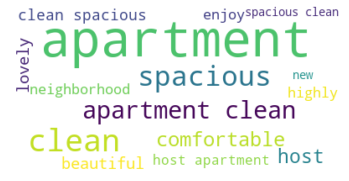

In [33]:
terms = vectorizer3.get_feature_names()
#declaring number of terms we need per topic
terms_count = 15
#Looping over lda components to get topics and their related terms with high probabilities
for idx,topic in enumerate(lda.components_):    
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)       
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("Topic#"+str(idx+1), format="png")
  

In [31]:
#Word cloud for each topic ?????


vocab_count = vectorizer3.get_feature_names()

topic_words = lda.components_
#  Define the number of Words that we want to print in every topic : n_top_words
n_top_words = 20
topics=[]
for i, topic_dist in enumerate(topic_words):
    
    # np.argsort to sorting an array or a list or the matrix acc to their values
    sorted_topic_dist = np.argsort(topic_dist)
    
    # Next, to view the actual words present in those indexes we can make the use of the vocab created earlier
    topic_words = np.array(vocab_count)[sorted_topic_dist]
    
    # so using the sorted_topic_indexes we are extracting the words from the vocabulary
    # obtaining topics + words
    # this topic_words variable contains the Topics  as well as the respective words present in those Topics
    topic_words = topic_words[:-n_top_words:-1]
topic_words

array(['apartment', 'clean', 'spacious', 'apartment clean', 'comfortable',
       'host', 'beautiful', 'lovely', 'clean spacious', 'neighborhood',
       'highly', 'enjoy', 'host apartment', 'spacious clean', 'new',
       'apartment spacious', 'quiet', 'clean apartment', 'easy'],
      dtype='<U22')

In [108]:
review_topic_matrix_df = pd.DataFrame(review_topic_matrix).add_prefix('topic_')
review_topic_matrix_df.head()


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.342233,0.013333,0.013333,0.013333,0.484433,0.013333,0.013333,0.013333,0.013333
1,0.310046,0.003704,0.255381,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.253935,0.003704,0.003704,0.139896,0.003704
2,0.005128,0.005128,0.005128,0.351494,0.256391,0.005128,0.005128,0.005128,0.072332,0.005128,0.005128,0.110250,0.158251,0.005128,0.005128
3,0.006061,0.006061,0.006061,0.181789,0.493636,0.006061,0.006061,0.006061,0.006061,0.251847,0.006061,0.006061,0.006061,0.006061,0.006061
4,0.002564,0.002564,0.002564,0.002564,0.002564,0.399665,0.276268,0.002564,0.002564,0.002564,0.002564,0.176838,0.119024,0.002564,0.002564


In [109]:
testing = df[ 'comments_cln'].tolist()

In [110]:
review_topic_matrix_df['comments'] = testing
review_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,comments
0,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.342233,0.013333,0.013333,0.013333,0.484433,0.013333,0.013333,0.013333,0.013333,lakshmee was amazing very nice for one night...
1,0.310046,0.003704,0.255381,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.253935,0.003704,0.003704,0.139896,0.003704,hyas place was awesome she was very helpful ...
2,0.005128,0.005128,0.005128,0.351494,0.256391,0.005128,0.005128,0.005128,0.072332,0.005128,0.005128,0.110250,0.158251,0.005128,0.005128,sharon is super nice the whole stay was great...
3,0.006061,0.006061,0.006061,0.181789,0.493636,0.006061,0.006061,0.006061,0.006061,0.251847,0.006061,0.006061,0.006061,0.006061,0.006061,nice apt nice bathroom nice mattress but ve...
4,0.002564,0.002564,0.002564,0.002564,0.002564,0.399665,0.276268,0.002564,0.002564,0.002564,0.002564,0.176838,0.119024,0.002564,0.002564,this was our first airbnb rental the place is...


####  Words/Topic Matrix

In [111]:
word_topic_matrix_df = pd.DataFrame(lda.components_, columns=vectorizer3.get_feature_names()).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
able,65.560126,38.336449,4.367684,63.790714,39.824966,167.523555,71.687154,10.412125,105.563410,4.081234,101.052672,47.589895,377.319474,26.152600,7.737942
absolute,0.066667,51.349921,31.590311,64.494157,0.066667,0.206891,0.365425,0.658314,1.289712,2.179977,0.066667,0.066667,1.392887,0.066667,0.139070
absolutely,49.979298,377.742375,201.764982,134.125219,67.735418,53.885879,31.141030,14.964214,58.182917,36.618402,0.636689,118.087725,23.085761,1.185377,152.864715
ac,4.900735,0.066667,0.066687,0.774031,0.066667,30.876131,0.095253,0.066667,0.461193,96.018501,0.920063,0.066667,414.429127,13.124944,0.066667
access,5.367030,0.241631,0.087079,0.310865,1.526478,106.277727,0.292505,1.006403,18.930942,17.429755,0.066667,0.066667,36.206906,1663.655695,0.533649


In [112]:
review_topic_matrix_df.to_pickle('review_topic_matrix_df.pickle')

In [113]:
word_topic_matrix_df.to_pickle('word_topic_matrix_df.pickle')

### Topic Interpretation CountVectorizer/LDA

In [115]:
def top_reviews(review_topic_matrix_df, topic, n_reviews):
    return (review_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]

#### For topic_0 lets find the reviews that have the highest expression

In [116]:
for comment in top_reviews(review_topic_matrix_df, 'topic_0', 10):
    print(comment)
    print()

safe neighbourhood in the heart of brooklyn    minute walk to subway and train line to midtown    minute ride    great way to see a different part of the city   joy s great  would definitely stay again 

the check in was great  very easy  location is nice and a grocery store and deli right next door  very close to bus and just a   minute walk to the metro  the amenities were very nice too  recommended on a budget for sure 

clean comfortable and well located with lots of restaurants and things to do near by  easy walk over the williamsburg bridge to manhattan or a short walk to the train  a great find 

mona s place is great  her apartment is very chic and clean  the location is great as well  there s an amazing roti place right around the block  and peaches  an amazing breakfast brunch spot   is a short     minute walk away   additionally  the subway is within only a few minutes  i would definitely suggest staying here to a friend 

this place is the perfect simple place for your nyc 

In [117]:
top_words(word_topic_matrix_df, 'topic_0', 15)

walk             3427.233804
minute           3179.202891
subway           2593.709879
train            2256.838518
minute walk      1356.811391
store            1238.985279
short            1173.890858
grocery           856.140685
close             794.161561
walk subway       762.816098
near              693.820131
clean             649.427340
grocery store     643.946921
short walk        599.171481
stop              564.130002
Name: topic_0, dtype: float64

In [118]:
print(top_words(word_topic_matrix_df, 'topic_4', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_4', 5):
    print(comment)
    print()
    

restaurant       2997.565397
walk             2181.322521
distance         1771.039620
shop             1677.942856
bar              1649.456004
walk distance    1501.066666
apartment         958.801025
subway            708.201534
close             707.818290
coffee            696.241326
Name: topic_4, dtype: float64
--------------
our stay in the apartment was as expected  very good   br   br  the area was quiet  good for sleeping  but there are a lot of shops and restaurants nearby   br   br  there are   subway stations at walking distance        street and    even   street station is not far  br   br  the building was being painted but even then it was quiet  br   br  ksenia is an incredible host  helping us a lot and giving us tips and recommendations about what to visit  restaurants to go to etc 

lovely hotel with superior customer service right in the heart of soho  surrounded by local bars and restaurants  walking distance to trader joe s  cvs and wine shop  br  i enjoyed the 

#### For topic_1 lets find the reviews that have the highest expression

In [119]:
print(top_words(word_topic_matrix_df, 'topic_1', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_1', 5):
    print(comment)
    print()
    


home            5748.863379
felt            2506.762624
safe            1711.532574
beautiful       1126.914419
experience      1011.215088
neighborhood     974.355509
lovely           861.325223
best             753.570534
welcome          674.506983
family           648.635906
Name: topic_1, dtype: float64
--------------
thank you geraldo for being such a great host  your lovely home is gorgeous and in the best neighborhood  we thoroughly appreciate your generosity and am so glad we added another week to our original   weeks  as we truly felt like a local and never wanted to leave  thank you fabricio for making us feel at home  we appreciate your time and knew you would come over if we needed anything    thank you for being a wonderful host and we hope your home is available again the next time we come to nyc 

we were completely charmed by the sweet pea cottage   as well as by kathleen   we felt like we were in europe in this tiny  cozy  adorable home  with home baked bread to greet

In [120]:
print(top_words(word_topic_matrix_df, 'topic_2', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_2', 5):
    print(comment)
    print()
    


host           4026.779196
responsive     1473.657864
excellent      1299.735921
clean          1282.607276
comfortable    1199.897245
fantastic      1038.709810
welcome         937.690765
highly          662.334827
hospitality     545.231457
lovely          536.237095
Name: topic_2, dtype: float64
--------------
runn is salt of the earth  as they say  fantastic host who went out of his way to make sure my stay was as pleasant as possible  the room was comfortable and the view was outstanding  can t beat that neighborhood either    has all the fun brooklyn stuff at yr doorstep  

mariluz was an excellent host  the place was super clean  in an excellent location  and mariluz was very communicative  she also left a binder of tips and tricks for exploring the city  overall  and excellent stay 

beautiful space with great art and decor  very clean with many spots to relax  timo is an excellent host and made us feel very welcome  highly recommend staying 

second time staying with lavonne a

In [121]:
print(top_words(word_topic_matrix_df, 'topic_3', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_3', 10):
    print(comment)
    print()
    

comfortable    1080.443502
right           916.627508
look            829.414270
street          704.832065
parking         703.834720
value           578.932564
bed             545.819097
spot            540.303255
old             387.890338
forward         367.064188
Name: topic_3, dtype: float64
--------------
not fancy  but just right   the neighborhood is quiet for brooklyn and has a variety of foods to try from pizza on the corner to chinese up and down the main street just a few doors away   all told a solid  good value and i look forward to returning 

man  another fabulous stay at billy s place  for those lucky enough to get some time here  you ll never be disappointed  i come again and again so you ll find my reviews occasionally on here  harlem is one of my very favorite places in new york  and billy s location and fantastic space will wow you almost as much as his generosity and charm 

ricardo and his place are great if you are looking to stay in the bronx  super clean  an

In [122]:
print(top_words(word_topic_matrix_df, 'topic_5', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_5', 5):
    print(comment)
    print()
    

kitchen      1984.858168
apartment    1097.397619
coffee        767.399206
bedroom       668.052394
space         656.851620
area          634.787781
towel         625.008123
cook          581.386883
provide       575.487064
equip         564.624347
Name: topic_5, dtype: float64
--------------
rob and glad were perfect hosts  nothing seemed a bother to either of them    br  however we feel they may have had to move out of their apartment to accommodate us   br  although we were there a week we had little space to hang our clothes and no drawer space even though the room was big enough to hold a chest of drawers   br  we had no kitchen except a makeshift table with microwave and toaster  kettle and coffee maker   br     br  in their favor they had left disposable bowls and breakfast cereal and other food and drink items for our convenience   br  overall we had a very pleasant experience but next time it may help if we read between the lines as there was no kitchen or washing up faciliti

In [123]:
print(top_words(word_topic_matrix_df, 'topic_6', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_6', 5):
    print(comment)
    print()
    

exactly        1505.019673
host           1111.378205
price          1111.287922
accommodate     967.300426
picture         956.010540
look            888.572821
flat            888.104123
clean           576.498578
amaze           529.681571
book            486.372411
Name: topic_6, dtype: float64
--------------
even if the flat is located in a vibrant area  it stays quiet as it does not face the street  flat is looking as in the pictures and reynald has be very quiet  we have booked one day in advacnce  and very helpful making sure we are enjoying our stay  definitely recommended  

sarah s apt is wonderful  she was an amazing host and very accommodating  the pictures are true to her apt  if anything i feel the apt in person is even better than the photos  i highly recommend staying at sarah s  

perfect studio apt in ues for one person  looks exactly like pictures  and got exactly what i expected 

this is by far the best listing you can get if you re looking for a prime location sp

In [442]:
print(top_words(word_topic_matrix_df, 'topic_8', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_8', 10):
    print(comment)
    print()

easy                2945.004701
space               2734.051640
clean               1279.631003
communicate         1032.424089
comfortable          548.551588
communication        533.589457
convenient           528.932730
easy communicate     473.066666
process              385.578047
hotel                385.125991
Name: topic_8, dtype: float64
--------------
this loft is gorgeous  i rented this space for my sisters bachelorette party  we had about   girls sleeping in the loft and there was plenty of room   if you really want to experience a city loft   this is the place to be  super stylish and the location was awesome as well  gregory was a pleasure to work with  communication was very fast and convenient  i highly recommend  

irene was a great host  the space was clean  conveniently located  and she was incredibly hospitable  we were able to drop our bags off early which was a complete life saver  we would love to stay again  

jenny s place would give any out of town visitor a 

In [443]:
print(top_words(word_topic_matrix_df, 'topic_9', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_9', 10):
    print(comment)
    print()

bed                3616.629167
clean              2587.280991
bathroom           1901.010403
comfortable        1792.861740
comfy              1271.614139
cozy               1072.882087
private             986.877996
bed comfortable     874.471882
shower              630.988302
small               616.477398
Name: topic_9, dtype: float64
--------------
adeyemi s place was super nice  the room was a little small but cozy  bed in our room was super soft  the common space showed as his pictures  the other people who stayed in other rooms were friendly as well  shower worked perfectly fine  not too hot nor too cold  i ll definitely stay at adeyemi s place again when i visit nyc next time  

great location  great value  simple space  bedroom seemed clean  bed was comfy  space was mostly very quiet except for a little bit of city noise  bathroom was shared with other guests  hosts seemed to be around but we didn t see too much of them 

this place is extreamly well located and the check in o

In [124]:
print(top_words(word_topic_matrix_df, 'topic_7', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_7', 10):
    print(comment)
    print()
    

close             3721.751389
subway            2071.662570
helpful           2008.174324
friendly          1950.373188
host              1642.549082
close subway      1548.716413
clean             1090.974440
transportation     857.935948
public             851.066647
easy               616.985884
Name: topic_7, dtype: float64
--------------
we had a great time in new york  the appartment was very nice and clean  maba was very kind and helpful  he gave us useful tips for new york  the appartment was close to the subway station and it was a good connection to the center  we would highly recommend this appartment  

ksenia and masha s place was nice  comfortable  and clean  it is close to a subway stop  so you can get to other areas of new york city pretty easily  

the place was very clean and cute  jackie was very responsive and very active in giving out suggestions of things to do and tips  the place was very close to public transit making it much easier to go around and visit places

In [444]:
print(top_words(word_topic_matrix_df, 'topic_10', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_10', 10):
    print(comment)
    print()

house     3456.438780
clean     1251.809801
host      1081.486509
new       1047.661625
kind       929.705619
help       748.072160
people     715.054461
guest      675.658715
enjoy      571.082241
person     559.721743
Name: topic_10, dtype: float64
--------------
my boyfriend and i loved our time in new york  we want to thank marquerite for making her place feel so welcoming and comfortable    br  we arrived early morning in ny and she allowed us to check in early which we greatly appreciated  the place was very clean  we were welcomed with fresh fruit and flowers  marquerite also gave us tips about how to get around ny  i would definitely recommend her place  great host and also very sweet person  thank you for a great experience    br  

living in kelvin s house is a real new york experience kelvin and his family were very kind  ready to help  easy going and welcoming they invited us to share with them barbeque and meals  always with friendship and dominican feeling we loved very m

In [445]:
print(top_words(word_topic_matrix_df, 'topic_11', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_11', 10):
    print(comment)
    print()

host             2917.318746
quick            2199.639576
question         1966.555340
respond          1760.371185
clean            1537.068166
communication    1087.448522
answer            946.472973
quickly           925.997359
highly            743.399282
quick respond     708.066666
Name: topic_11, dtype: float64
--------------
very clean  stylish place for a great value  host was communicative  kind  attentive  and helpful  i enjoyed a peaceful stay in a quaint atmosphere  highly recommend 

shirley  is such a doll  fast communication  kind  down to earth  such great positive energy  understanding  laid back  and down to earth  i can t wait to stay here again  i would rate her   stars  if i could  the place is clean  cute  simple  and as pictured 

t   n is a great place to stay  it was immaculately clean and the hosts are very quick to respond to any questions or concerns  i would highly recommend this place to anyone 

highly recommend staying at mike s place  it s quiet  clea

In [447]:
print(top_words(word_topic_matrix_df, 'topic_12', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_12', 10):
    print(comment)
    print()

apartment    1662.715824
door         1024.957637
use           974.473847
work          933.198970
host          925.716159
floor         914.718572
leave         906.649810
noise         904.975137
thing         846.036359
sleep         753.254687
Name: topic_12, dtype: float64
--------------
the apartment was like living in the middle of a freeway        a window air conditioner in bedroom amplified the problem of noise from the very busy   ave  it faces    construction on   street  which the living area faces  meant there was no place to go to for any moderate noise levels   we tried sleeping on the bathroom floor one night and after many nights with no sleep gave up and started staying elsewhere   it was costly to do that  but our trip was ruined from not being able to sleep    br  we are not primadonnas and we know and love busy  noisy cities   we live in a very busy  noisy  city ourselves   but this was over the top   it was awful   had the noise level been accurately stated we 

In [449]:
print(top_words(word_topic_matrix_df, 'topic_13', 10) )
print ('--------------')

for comment in top_reviews(review_topic_matrix_df, 'topic_13', 10):
    print(comment)
    print()

park            2386.861246
subway          1930.341579
quiet           1821.741384
easy            1763.341337
access          1663.655695
neighborhood    1354.418103
central         1344.763277
block           1099.512081
close            935.354028
easy access      897.066351
Name: topic_13, dtype: float64
--------------
such a great location with parking fairly easy to find  restaurants  stores  etc very nearby in a safe cute neighborhood  subway line a block away and beautiful prospect park right there too  the apartment was just what we needed and great for a family  

sabrina s apartment is great   the location is a particularly good  two blocks from four different train lines  all of which run express in manhattan   and also from the brooklyn botanical gardens  prospect park and the brooklyn museum   the neighborhood has a good atmosphere  and there are a lot of great restaurants nearby   i definitely recommend 

great location  fairly quiet area and close to central park  so i

In [452]:
print(top_words(word_topic_matrix_df, 'topic_14', 10) )
print ('--------------')
for comment in top_reviews(review_topic_matrix_df, 'topic_14', 5):
    print(comment)
    print()

apartment          10280.146889
clean               2506.727839
spacious            1962.944743
apartment clean     1510.665376
comfortable          997.654286
host                 935.135573
beautiful            613.724264
lovely               610.507943
clean spacious       533.576532
neighborhood         467.979209
Name: topic_14, dtype: float64
--------------
our holiday in nyc was amazing thanks also to eric and erika s kindness and thanks to their apartment  the apartment is so cozy  clean and they have attention to the details  it is near to the metro station and this is a very important detail that allows you to visit ny without problems 

lane s place was beautiful  clean  and comfortable  he was an attentive host and contacted me to see if i wanted to stay an additional day because of the snow storm  i enjoyed staying at his bright and sunny apartment and will definitely stay there again on my next visit to williamsburg  thanks lane  

lovely clean apartment  nice quiet locat

# CorEx

In [84]:
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt 

In [85]:
vectorizer = CountVectorizer(stop_words = custom_stopwords,
                              ngram_range=(1,2),
                                max_df = 0.7, 
                                min_df = 10,max_features = 1000, binary=True)
doc_word = vectorizer.fit_transform(docs)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(43947, 1000)

In [86]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

## CorEx Topic Model

-n_hidden: number of topics ("hidden" as in "hidden latent topics")
    
-words: words that label the columns of the doc-word matrix (optional)
    
-docs: document labels that label the rows of the doc-word matrix (optional)
    
-max_iter: number of iterations to run through the update equations (optional, defaults to 200)
    
-verbose: if verbose=1, then CorEx will print the topic TCs with each iteration
    
-seed: random number seed to use for model initialization (optional)

In [87]:
# Train the CorEx topic model with 20 topics
topic_model = ct.Corex(n_hidden=20, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [95]:
topic_model.get_top_docs(topic=4, n_docs=2)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(5274, 0.0), (120, 0.0)]

The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. CorEx also returns the "sign" of each word, which is either 1 or -1. If the sign is -1, then that means the absence of a word is informative in that topic, rather than its presence.

If the column labels have not been specified through words, then the code will return the column indices for the top words in each topic.

In [94]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))
    


0: walk, subway, restaurant, distance, minute, walk distance, shop, minute walk, block, bar
1: bed, bed comfortable, towel, comfy, comfortable bed, tv, fridge, bedroom, water, use
2: bathroom, door, noise, window, thing, work, hear, guest, light, share
3: close, close subway, easy, access, easy access, public, transportation, easy communicate, public transportation, close train
4: felt, experience, felt safe, felt home, long, best, know, provide, live, family
5: respond, quick, quick respond, respond quickly, response, quickly, quick response, respond question, host quick, host respond
6: shower, hot, small, sleep, money, people, ac, ceiling, price, value money
7: flight, arrive, late, arrival, early, hour, key, air, able, luggage
8: store, grocery, coffee, grocery store, coffee shop, plenty, food, dryer, washer, space
9: quiet, street, neighborhood, line, bus, subway line, clean quiet, quiet neighborhood, parking, safe neighborhood
10: apartment, apartment clean, new, host apartment, 

In [471]:
topic_model.tc

4.241670973156384

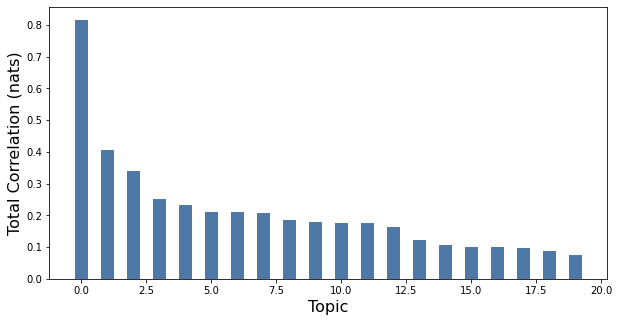

In [472]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [473]:
# Train the CorEx topic model with 7 topics
topic_model2 = ct.Corex(n_hidden=7, words=words, max_iter=200, verbose=False, seed=1)
topic_model2.fit(doc_word, words=words);

In [488]:
# Print all topics from the CorEx topic model
topics2 = topic_model2.get_topics()
for n,topic in enumerate(topics2):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: subway, walk, restaurant, close, shop, distance, close subway, park, walk distance, block
1: bed, kitchen, bed comfortable, bedroom, street, use, towel, sleep, comfortable bed, floor
2: bathroom, shower, small, work, air, water, hot, tv, thing, guest
3: felt, home, arrive, leave, late, new, felt safe, meet, felt home, welcome
4: apartment, clean, comfortable, spacious, apartment clean, clean comfortable, look, decorate, exactly, clean spacious
5: minute, respond, quick, minute walk, easy, quick respond, short, city, quickly, short walk
6: question, provide, answer, coffee, answer question, available, plenty, host, visit, ask


In [475]:
topic_model2.tc

3.813589226736776

In [494]:
# Train the CorEx topic model with 15 topics
topic_model3 = ct.Corex(n_hidden=15, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model3.fit(doc_word, words=words);

In [495]:
# Print all topics from the CorEx topic model
topics3 = topic_model3.get_topics()
for n,topic in enumerate(topics3):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: subway, walk, restaurant, close, distance, close subway, shop, walk distance, park, block
1: bathroom, kitchen, bedroom, use, floor, towel, noise, small, sleep, shower
2: question, respond, quick, answer, quick respond, quickly, answer question, response, exactly, message
3: home, felt, new, welcome, city, visit, felt home, home home, experience, forward
4: clean, apartment, comfortable, safe, apartment clean, spacious, clean comfortable, public, felt safe, clean spacious
5: minute, minute walk, street, grocery, short, grocery store, short walk, corner, right, subway minute
6: ask, thing, money, guest, think, couldn, review, hotel, tell, pay
7: arrive, kind, late, leave, meet, sure, help, flight, house, know
8: bed, bed comfortable, comfortable bed, comfy, comfy bed, bed comfy, clean bed, sofa, pillow, soft
9: coffee, breakfast, provide, morning, coffee shop, fully, snack, couple, tea, stock
10: easy, quiet, access, easy access, responsive, clean quiet, easy communicate, host respon

In [497]:
# Train the CorEx topic model with 15 topics
topic_model4 = ct.Corex(n_hidden=12, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model4.fit(doc_word, words=words);

In [498]:
# Print all topics from the CorEx topic model
topics4 = topic_model4.get_topics()
for n,topic in enumerate(topics4):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: kitchen, towel, bedroom, use, noise, fridge, water, floor, sleep, tv
1: walk, distance, walk distance, minute walk, shop, minute, store, grocery, walk subway, block
2: subway, close, restaurant, close subway, bar, easy, access, easy access, line, public
3: respond, quick, arrive, leave, quick respond, late, quickly, flight, message, arrival
4: answer, answer question, question, thing, small, shower, work, money, stair, problem
5: comfortable, bed, clean comfortable, bed comfortable, clean, comfy, comfortable bed, comfortable clean, comfy bed, bed comfy
6: felt, home, safe, welcome, felt safe, felt home, home home, decorate, safe neighborhood, neighborhood safe
7: apartment, quiet, apartment clean, park, neighborhood, central, central park, clean quiet, host apartment, lovely
8: bathroom, space, share, private, area, large, people, bathroom clean, live, common
9: host, helpful, spacious, friendly, extremely, clean spacious, highly, communicate, excellent host, easy communicate
10: st

In [499]:
topic_model4.tc

4.048097416429661

In [478]:
# Anchor one word to the first topic
anchor_words = [['subway','walk'], ['bed','bathroom'], ['neighborhood'], ['host'] ]

In [489]:
# With Anchor words
anchored_topic_model = ct.Corex(n_hidden=15, seed=2)
anchored_topic_model.fit(doc_word, words=words, docs=docs, anchors=[['subway','walk'], ['bed','bathroom'], 'neighborhood', 'host' ], 
                         anchor_strength=6);

In [496]:
anchored_topic = anchored_topic_model.get_topics()
for n,topic in enumerate(anchored_topic):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: subway, walk, close subway, walk distance, distance, minute walk, minute, walk subway, short walk, subway line
1: bed, bathroom, bed comfortable, comfortable, comfortable bed, comfy, comfy bed, bed comfy, bathroom clean, clean bed
2: neighborhood, quiet neighborhood, safe neighborhood, neighborhood safe, neighborhood quiet, neighborhood close, apartment neighborhood, lively
3: host, excellent host, host apartment, host responsive, friendly host, host friendly, host helpful, fantastic host, host easy, helpful host
4: noise, door, hear, building, stair, thing, outside, loud, open, problem
5: use, towel, shower, bedroom, work, water, hot, air, small, tv
6: respond, quick, public, quiet, quick respond, street, clean quiet, public transportation, quickly, transportation
7: space, kitchen, living, plenty, cook, large, space clean, stock, common, sparkle
8: restaurant, close, shop, bar, store, park, train, grocery, block, access
9: house, help, house clean, dryer, person, available, includ

# Sentiment Analysis to detect negative and positive reviews

Sentiment analysis is the process of identifying people's emotional states from text data. In this project, it will help to classify negative and positive reviews.



In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
for sentence in df['comments'].values[1:3]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Hyas place was awesome!  She was very helpful and informative upon arrival.  She showed us around the place and gave us tips for things to do and places to eat around the neighborhood.  The place was quiet and big.  Plenty bang for your buck.  She even offered a ride to the train station upon check it to make sure we caught our flight on time.  Hya was amazing and I’d book with her again for sure!
compound: 0.9449, neg: 0.0, neu: 0.812, pos: 0.188, 
Sharon is super nice. the whole stay was great! We were group of six, having late night conversations. there was no problem, if we needed anything, we texted and got reply right away. The location is perfect, subway, cafe and little shop right across the street. We loved it. The place was super clean. 
compound: 0.9698, neg: 0.065, neu: 0.598, pos: 0.336, 


From VaderSentiment :

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
\
negative sentiment: compound score <= -0.05

In [58]:
pscores = [sid.polarity_scores(comment) for comment in df['comments']]

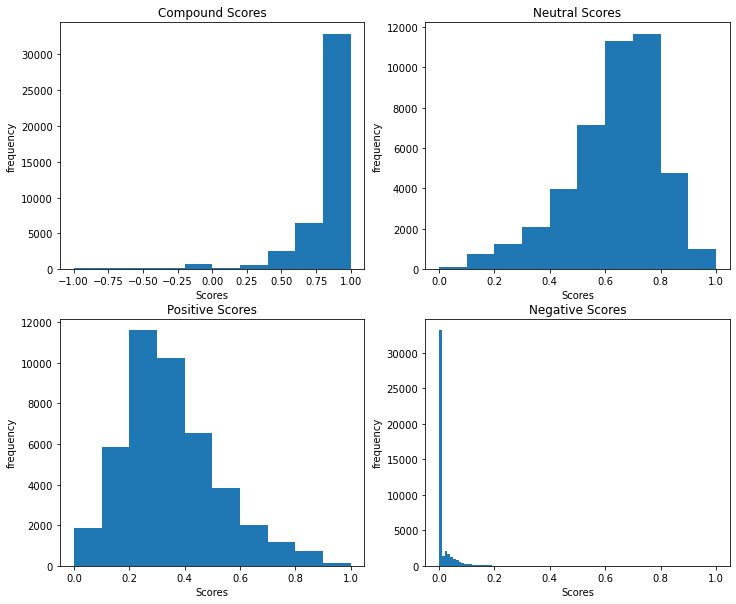

In [42]:
plt.subplots(figsize=(12,10))

plt.subplot(2, 2, 1)
pd.Series([score['compound'] for score in pscores]).plot(kind='hist')

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 2)
#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 3)

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 4)
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=100)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')


plt.savefig('sentiment.png',dpi =150)

#the negative scores were mostly close to zero. Most guest had pleasant experiences during their Airbnb stays.

In [59]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews['comments'] = df.comments
scored_reviews['comments_lmn'] = df.comments_lmn
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [272]:
scored_reviews.head()

,comments,comments_lmn,compound,negativity,neutrality,positivity
690518,Lakshmee was amazing ! Very nice for one night...,lakshmee be amaze very nice for one night she ...,0.9310,0.000,0.636,0.364
620226,Hyas place was awesome! She was very helpful ...,hyas place be awesome she be very helpful and ...,0.9449,0.000,0.812,0.188
560286,Sharon is super nice. the whole stay was great...,sharon be super nice the whole stay be great w...,0.9698,0.065,0.598,0.336
795187,"Nice apt, nice bathroom, nice mattress, but ve...",nice apt nice bathroom nice mattress but very ...,0.8466,0.067,0.592,0.341
846818,This was our first Airbnb rental. The place is...,this be our first airbnb rental the place be e...,0.9402,0.033,0.775,0.192


In [273]:
scored_reviews.query('negativity > positivity')

,comments,comments_lmn,compound,negativity,neutrality,positivity
389535,Place was as described. Everything was okay an...,place be a described everything be okay and ba...,-0.3708,0.096,0.869,0.035
847869,This stay was a disaster. The apartment was ve...,this stay be a disaster the apartment be very ...,-0.6757,0.128,0.819,0.053
729377,"No fridge, no proper A/C, $100/night deposit, ...",no fridge no proper a c night deposit and no v...,-0.4404,0.251,0.646,0.103
487828,"Clean, but no frills. Bathroom needs some cosm...",clean but no frill bathroom need some cosmetic...,-0.2382,0.168,0.721,0.111
798842,WRONG ROOM THEIR IS NO EMPIRE STATE BUILDING V...,wrong room their be no empire state building v...,-0.6900,0.255,0.670,0.075
...,...,...,...,...,...,...
537051,Bathroom was freezing. Shower walls had hair f...,bathroom be freeze shower wall have hair from ...,-0.8968,0.214,0.715,0.071
779920,Omg where do I start?! I stayed here for 2 wee...,omg where do i start i stay here for week and ...,-0.9717,0.137,0.808,0.055
504057,there was a big noise at early morning from ve...,there be a big noise at early morning from ven...,-0.0956,0.142,0.765,0.094
111459,"Unfortunately, we didn't get the room we have ...",unfortunately we didn t get the room we have b...,-0.0790,0.090,0.826,0.084


In [67]:
neg_reviews = scored_reviews.query('compound< -0.05')

In [176]:
pos_reviews = scored_reviews.query('compound > 0.05')

In [68]:
neg_reviews.shape

(745, 6)

In [177]:
pos_reviews.shape

(42576, 6)

In [69]:
neg_reviews

,comments,comments_lmn,compound,negativity,neutrality,positivity
389535,Place was as described. Everything was okay an...,place be a described everything be okay and ba...,-0.3708,0.096,0.869,0.035
847869,This stay was a disaster. The apartment was ve...,this stay be a disaster the apartment be very ...,-0.6757,0.128,0.819,0.053
729377,"No fridge, no proper A/C, $100/night deposit, ...",no fridge no proper a c night deposit and no v...,-0.4404,0.251,0.646,0.103
487828,"Clean, but no frills. Bathroom needs some cosm...",clean but no frill bathroom need some cosmetic...,-0.2382,0.168,0.721,0.111
798842,WRONG ROOM THEIR IS NO EMPIRE STATE BUILDING V...,wrong room their be no empire state building v...,-0.6900,0.255,0.670,0.075
...,...,...,...,...,...,...
537051,Bathroom was freezing. Shower walls had hair f...,bathroom be freeze shower wall have hair from ...,-0.8968,0.214,0.715,0.071
779920,Omg where do I start?! I stayed here for 2 wee...,omg where do i start i stay here for week and ...,-0.9717,0.137,0.808,0.055
504057,there was a big noise at early morning from ve...,there be a big noise at early morning from ven...,-0.0956,0.142,0.765,0.094
111459,"Unfortunately, we didn't get the room we have ...",unfortunately we didn t get the room we have b...,-0.0790,0.090,0.826,0.084


In [180]:
pos_reviews.head()

,comments,comments_lmn,compound,negativity,neutrality,positivity
690518,Lakshmee was amazing ! Very nice for one night...,lakshmee be amaze very nice for one night she ...,0.9310,0.000,0.636,0.364
620226,Hyas place was awesome! She was very helpful ...,hyas place be awesome she be very helpful and ...,0.9449,0.000,0.812,0.188
560286,Sharon is super nice. the whole stay was great...,sharon be super nice the whole stay be great w...,0.9698,0.065,0.598,0.336
795187,"Nice apt, nice bathroom, nice mattress, but ve...",nice apt nice bathroom nice mattress but very ...,0.8466,0.067,0.592,0.341
846818,This was our first Airbnb rental. The place is...,this be our first airbnb rental the place be e...,0.9402,0.033,0.775,0.192


In [70]:
doc_neg = neg_reviews['comments_lmn']

In [178]:
doc_pos = pos_reviews['comments_lmn']

C:\Users\12157\AppData\Local\Temp/ipykernel_10584/3072095588.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


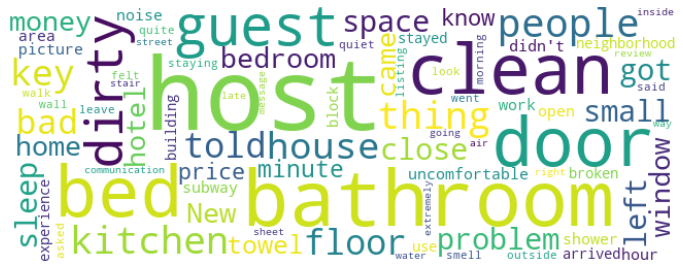

In [173]:
from PIL import Image

#mask = np.array(Image.open("house.png"))
words = " ".join(str(w) for w in neg_reviews['comments'])
plt.subplots(figsize=(12,6))
wordcloud = WordCloud(stopwords =custom_stopwords1, background_color='white',width=650,height=250,max_words=80).generate(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig('neg.png')
plt.show()




In [172]:
stopwords_addition1 = ['apartment', "airbnb", "bnb", "a", "aa", "aaa", "br", "york", "need", "make",
                      "good", "great", "perfect", "br", "amazing", "recommend", "place", "like", "nice",
                    "room", "stay", "overall", "really", "check",  "unit", "did", "didn", "day",
                    "night", "just", "super", "love",  "days", "lot","awesome", "ny",
                    "definitely", "wonderful", "reservation",  "s", "locate","nyc", "location",'thanks','thank', "brooklyn", 
                      "manhattan", "away", "station", "time", "come","thoroughly","ve",'t','feel','want','don','say','wasn','min',
                     'bit','little','let','issue','big']
custom_stopwords1 = text.ENGLISH_STOP_WORDS.union(stopwords_addition1)

C:\Users\12157\AppData\Local\Temp/ipykernel_10584/4122475155.py:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


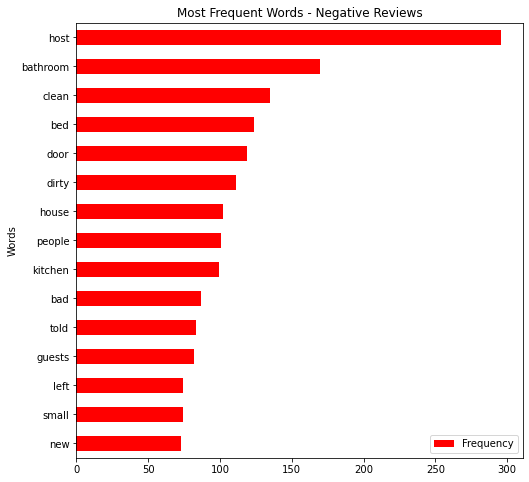

In [174]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words= custom_stopwords1).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(neg_reviews['comments'], 15)
df2 = pd.DataFrame(common_words, columns = ['Words' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df2.sort_values(by='Frequency').plot.barh(x='Words',
                      y='Frequency',
                      ax=ax,
                      color="red")

ax.set_title("Most Frequent Words - Negative Reviews")
plt.savefig('unigram_hist_neg.png',bbox_inches = 'tight')
plt.show()

C:\Users\12157\AppData\Local\Temp/ipykernel_10584/3636845180.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


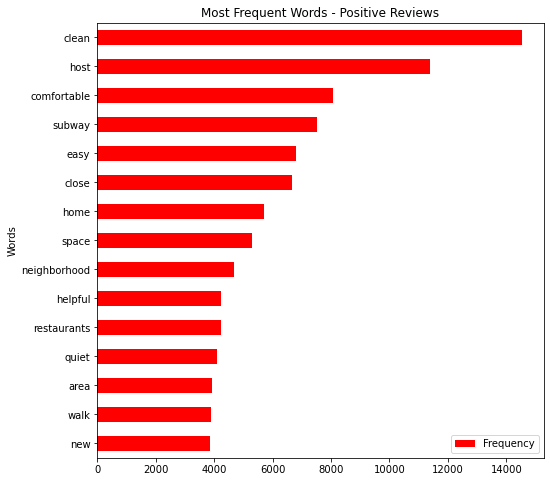

In [181]:
common_words_pos = get_top_n_words(pos_reviews['comments'], 15)
df3 = pd.DataFrame(common_words_pos, columns = ['Words' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df3.sort_values(by='Frequency').plot.barh(x='Words',
                      y='Frequency',
                      ax=ax,
                      color="red")

ax.set_title("Most Frequent Words - Positive Reviews")
plt.savefig('unigram_hist_pos.png',bbox_inches = 'tight')
plt.show()

In [ ]:
lda = LatentDirichletAllocation(n_components=15, random_state=10)


In [185]:
preprocessor = None
vectorizer4 = CountVectorizer(stop_words = custom_stopwords1,
                              ngram_range=(1,2),
                                max_df = 0.7, 
                                min_df = 10,max_features = 1000)


make_topics(doc_neg, preprocessor, vectorizer3, lda);

Topic 0:
 CLEAN, BAD, BATHROOM, GUEST, FLOOR, BED, SMELL, APARTMENT, HOTEL, SHEET 

Topic 1:
 APARTMENT, PROBLEM, WALK, CLEAN, HOST, MEET, NEAR, QUITE, NEW, CLOSE 

Topic 2:
 APARTMENT, GUEST, KEY, BREAK, HOST, TELL, ARRIVE, BATHROOM, OPEN, LOCK 

Topic 3:
 PRICE, PAY, BAD, COMPLAINT, KNOW, PARKING, STEAL, TV, ACCOMMODATE, CHARGE 

Topic 4:
 PARK, AREA, CAR, BED, BLOCK, SLEEP, UNCOMFORTABLE, WALK, SUBWAY, PARKING 

Topic 5:
 BATHROOM, BED, APARTMENT, SMALL, CLEAN, HOST, SMELL, HOUSE, DOOR, BEDROOM 

Topic 6:
 DIRTY, BLOCK, BED, BATHROOM, WALK, CLEAN, WORK, SLEEP, KITCHEN, HOME 

Topic 7:
 GUEST, LEAVE, USE, THING, UNCOMFORTABLE, TELL, BED, KITCHEN, SLEEP, ABLE 

Topic 8:
 WATER, CLEAN, SHOWER, APARTMENT, FLOOR, EXPECT, HOT, EXTREMELY, HOT WATER, DOOR 

Topic 9:
 HOST, APARTMENT, SLEEP, HOUSE, WALK, LEAVE, DOOR, QUIET, BAD, MINUTE 

Topic 10:
 APARTMENT, CLOSE, SUBWAY, STREET, FLAT, PROBLEM, BUILDING, CLEAN, WORK, EXPECT 

Topic 11:
 HOST, NOISE, WINDOW, LOUD, APARTMENT, EXPERIENCE, INS

In [187]:
p1 = pyLDAvis.sklearn.prepare(LatentDirichletAllocation(n_components=15, random_state=10).fit(vectorizer4.fit_transform(doc_neg)), 
                              vectorizer4.fit_transform(doc_neg),vectorizer4,mds = 'mmds')

pyLDAvis.display(p1)

In [188]:

lda.fit(vectorizer4.fit_transform(doc_neg))

neg_topic_matrix = lda.transform(vectorizer4.fit_transform(doc_neg))
neg_topic_matrix_df = pd.DataFrame(neg_topic_matrix).add_prefix('topic_')
testing = neg_reviews['comments'].tolist()
neg_topic_matrix_df['comments'] = testing
word_topic_neg_df = pd.DataFrame(lda.components_, columns=vectorizer4.get_feature_names()).T.add_prefix('topic_')

print(top_words(word_topic_neg_df, 'topic_0', 10) )
print ('--------------')

for comment in top_reviews(neg_topic_matrix_df, 'topic_0', 10):
    print(comment)
    print()
    

flat          26.076922
clean         17.009711
charge        13.701527
small         13.440809
thing         12.665151
home          12.172797
luggage       12.050939
convenient    11.549610
bad           10.758849
close         10.583199
Name: topic_0, dtype: float64
--------------
Most horrible Airbnb experience I ever had, we had to call Airbnb customer service and move to an other place.<br/>Ian was abroad so he told us that his roommate James would welcome us.<br/>We first had to ask for the address of the apartment (not written on Airbnb) and then for the roommate phone number.<br/>He never answered to our next messages about dropping our luggage and our check-in.<br/>So for our check-in we had to see with the roommate, we asked for dropping our luggage in the morning, he told us to come when we want in the morning and to keep calling him until he wakes up. He never answered, we arrived at 9 am and he answered at 2 am... so we began by loosing half a day of our trip.<br/>Then, w

In [130]:

print(top_words(word_topic_neg_df, 'topic_1', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_1', 5):
        print(comment)
        print()

apartment      29.228985
minute         22.849636
walk           20.330269
problem        17.357619
near           11.917283
clean          11.631482
space          10.498526
minute walk    10.066666
Name: topic_1, dtype: float64
The kitchenette is very well equipped and exceeds expectations. We enjoyed walking to a number of restaurants and bakeries that were nearby. Finding parking was not a problem at all. The directions to get into Manhattan using mass transit are spot on; there is even a pharmacy near the bus stop to buy a MTA card. This might be in the listing's description and I missed it or forgot about it, but there is a low clearing to enter the apartment that most people will need to watch out for. I'm 5'8" and hit my head once. With the current couch, I cannot recommend having a third person stay in the space, even if it is a small child. 

Matt's place is in a great location on the Williamsburg/Greenpoint border, just down the road from the G train and around a 10 minute w

In [131]:
print(top_words(word_topic_neg_df, 'topic_2', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_2', 5):
        print(comment)
        print()

apartment    77.034952
bathroom     68.728955
guest        49.905748
host         43.162401
dirty        41.629949
door         40.850194
break        37.327052
kitchen      36.894446
Name: topic_2, dtype: float64
The stay at Peter’s was bitter sweet.<br/> We arrived and Elo, his wife was very welcoming, she had even bought us goodies ( soaps, tooth brushes, sponges). A few days later the key broke in the hallway lock and we informed Peter of what had happened. He wasn’t helpful at all and was very ironic to us. We tried to explain what had happened ( we know it was a faulty key as we saw another broken key stuck with tape on top of the door) and Peter started accusing us and demoted us in a very ugly way. <br/>We stood still and we were shocked when we read his message. We tried to explain what had happened and when he realized that key number 2 was the key of the hallway and not the key of the apartment he said he would come over and give us and new one. Yes, in the end he resolved t

In [132]:
print(top_words(word_topic_neg_df, 'topic_3', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_3', 5):
        print(comment)
        print()

clean     14.491758
host      11.450775
steal     10.865261
leave     10.600549
new        8.086476
know       7.918105
bad        7.494516
wouldn     7.417856
Name: topic_3, dtype: float64
I would not recommend this place. It is not clean or sanitary. To paint a picture it looks as if the place hasn’t been vacuumed or mopped in months or more. There were stains on the beds. The bathroom window is covered up by taped up newspaper that is torn up. Literally instead of a curtain there is a newspaper taped against the window. The bathroom is so small I don’t know how anyone would manage a shower in there. I wouldn’t know because I left immediately after I walked into this apt and found a new accommodation. I literally paid for this stay and just left and paid for another one. The parking is the only upside. If you don’t mind an apt that is not kept up and cleaned and just want a cheap place to sleep then stay here. Even then.. there are places in queens and Brooklyn at similar rates that 

In [133]:
print(top_words(word_topic_neg_df, 'topic_4', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_4', 5):
        print(comment)
        print()

complaint    19.038410
parking      18.101893
car          18.056040
area         15.730636
park         10.811878
flat         10.517284
street       10.367792
help          9.690242
Name: topic_4, dtype: float64
The apartment was clean and well taken care of. The only issue was parking because we were told we could park anywhere we fit without being told we couldn’t park in front of the neighbors unused, gated driveway. The next morning all 4 tires of our car were FLAT in the road. After bringing the situation up with the host she just told us we weren’t suppose to park there and could not help us or take us 4 min to Pep Boys for an air compressor. She also said she had seen the car the night prior but “thought” the neighbors must have got a new car even though we were the only car with an out of state plate on the whole block (Michigan plate). We just wished she would’ve told us after seeing an unknown car especially because she could see the car from the front door. The only help s

In [134]:
print(top_words(word_topic_neg_df, 'topic_5', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_5', 5):
        print(comment)
        print()

apartment     40.073413
host          26.460568
small         21.468532
bathroom      19.221864
bed           18.658575
experience    16.106691
ac            15.898110
clean         15.872563
Name: topic_5, dtype: float64
We had a great experience in New York and the apartment is so nice and clean. Zaza was also so nice providing us with towels and also the check in was easy (you just take the key from downstairs so we didn’t wait). But we must say something: <br/><br/>1.- The neighbourhood is not very safe (at least during the night, the streets are so dark and they look a bit dangerous, even we took some ubers from the metro till the house). Indeed, the metro is not 10 minutes far away from the metro, but 15-20 (and I walk fast!). <br/><br/>2.- The apartment is nice, luminous and quiet but the room has inflatable mattresses. For one-two days is okay, but not for one week. I think that should be said that in the announcement, because it is not clear in the pictures.<br/><br/>3.- In th

In [135]:
print(top_words(word_topic_neg_df, 'topic_6', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_6', 5):
        print(comment)
        print()

block            51.258213
park             29.657900
walk             25.692127
subway           20.264207
convenient       14.318932
walk distance    13.961887
distance         13.751522
neighborhood     13.485305
Name: topic_6, dtype: float64
I love just about everything about this place! It had any amenity you could think of and was a pretty spacious space. It is right about the corner from the A,C,L,J, and, Z trains which is super convenient. My only negative of this rental has nothing to do with unit itself but rather it’s upstairs tenants - they are very loud. I was here for work and worked from home a lot and the dog upstairs cries and howls all day when the owners aren’t home. Also, there is running/stomping and loud music that would go on all day and as late as 3 am that was sometimes hard to sleep though but that is really the only negative I experienced.

There are two sets of stairs to climb to get into the place, just in case anyone has difficulty with stairs. You are not

In [136]:
print(top_words(word_topic_neg_df, 'topic_7', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_7', 5):
        print(comment)
        print()

price            26.982929
uncomfortable    26.181990
bed              23.939502
use              21.525613
clean            19.900340
picture          18.803930
look             18.589950
home             18.578726
Name: topic_7, dtype: float64
It's my worst experience with a host. Thank goodness airbnb stepped up and made things right. Pros - looks as it's shown. Really charming common spaces, very spacious. Large library and DVD collection. Cons- we didn't get to enjoy them as TV was not plugged in. But that's fine. We were out most of the day for sightseeing anyways. Bedroom - as described but double bed was so bumpy and also sunk that my 60 lbs daughter and I kept rolling into the middle of it, just to try to stay at some level of comfort, which in the morning I woke up with back pain. We also had an airmattress for my other daughter. In the middle of the night she moved into the living room couch because the mattress deflated and she was sloshing in it left and right. She was ver

In [138]:
print(top_words(word_topic_neg_df, 'topic_8', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_8', 3):
        print(comment)
        print()

expect       22.605744
clean        21.198528
thing        17.138379
look         16.209592
apartment    14.576100
small        14.012791
sleep        13.968499
host         11.715906
Name: topic_8, dtype: float64
Upon first glance things seemed fine. The sheets were clean the beds were made and there were fresh towels. However there were crumbs and dust all over the apartment and under both beds. Moldy fruit in the refrigerator. It appeared as if someone had picked their nose and wiped it on the walls of the bedroom. The floor was incredibly sticky. The area rug was covered in lint, hair, and dust bunnies. There were dishes that were expected to be washed after use but guests were not provided with kitchen sink or dish soap.  <br/><br/>Listing says that unit was supposedly recently updated, many fixtures appeared as they needed to be updated or that they were unfinished<br/><br/>Prior to our trip, I had asked the host with a possible earliest check-in time would be, I was told 3 PM.  

In [139]:
print(top_words(word_topic_neg_df, 'topic_9', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_9', 5):
        print(comment)
        print()

host         50.402120
apartment    50.262568
walk         31.805962
sleep        26.734475
house        25.076939
quiet        20.156313
key          19.281376
upstairs     16.549352
Name: topic_9, dtype: float64
Pros: Location is amazing, lots of great places to eat and drink in the area. The place is exactly as describes, the apartment is quite large so lots of room, some dog hair but it is pet friendly which is why we initially chose this place although didn't end up bringing our pets. Everything you need is in the apartment. Easy lockbox entry, owner provides instructions well before arrival time. No a/c but has a wonderful breeze if you open all windows. <br/><br/>Cons: I believe construction is pretty typical of New York city, however they are literally building an apartment complex next to and behind this building, extremely noisy pretty much all day even on Saturday morning which was disappointing. No air-conditioning so later in the summer would be hard. The biggest frustrati

In [140]:
print(top_words(word_topic_neg_df, 'topic_10', 8) ) 

for comment in top_reviews(neg_topic_matrix_df, 'topic_10', 5):
        print(comment)
        print()

apartment    48.130174
close        36.277693
window       35.049227
subway       33.149157
noise        31.376703
street       23.970721
building     22.456697
sleep        19.856646
Name: topic_10, dtype: float64
<br/>Other problems we had were no microwave and no space to put your clothes out (we lived out of suitcases). I wouldn't stay here during the winter until the valves for the steam heating in both the bedroom and bathroom are fixed, due to the noise and also the condensation problem from the steam entering the apartment.

The house is overall fine. The room is large, floors are clean because no shoes allowed beyond the entrance. Amenities are fine besides the main light in my room isn't working and I have to use the lamp instead. The apartment isn't far from the subway station and routes are clear and straightforward. Take around 30-40minutes to port authority bus terminal. The main point that disturbed my stay was the lack of responsiveness of the host. It usually take hour

In [ ]:
Topic 0 - Dirtiness
Topic 1 - Location - mostly positive 
Topic 2 - Inaccurate Listings descriptions
Topic 3 - Negative Airbnb experience - Host's unpleasent behavior 
Topic 4 - Communication
Topic 5 - Inaccurate Listings descriptions
Topic 6 - Noise
Topic 7 - Poor house maintenance

Topic 9 - S
Topic 10 - Unmatched descriptions 
Topic 11 - Bathroom 
Topic 12 - Location general
Topic 13 - Location convenience
Topic 14


In [ ]:
Topic 1 - Inaccurate listings 
Topic 2 - Check-in/out
Topic 3 - Bed/Bathroom 
Topic 4 - Dirtiness and smell 
Topic 5 - Uncomfortable sleep conditions
Topic 6 - Location
Topic 7 - Poor house maintanence
Topic 8 - Noise
Topic 9 - Hot Water/Heater 
Topic 10 - Dirtiness
Topic 11 - Location
Topic 12 - Location general
Topic 13 - Overpriced

In [79]:
p1 = pyLDAvis.sklearn.prepare(LatentDirichletAllocation(n_components=13, random_state=10).fit(vectorizer3.fit_transform(doc_neg)), 
                              vectorizer3.fit_transform(doc_neg),vectorizer3,mds = 'mmds')

pyLDAvis.display(p1)

In [141]:

lda = LatentDirichletAllocation(n_components=13, random_state=10)
lda.fit(vectorizer3.fit_transform(doc_neg))

neg_topic_matrix = lda.transform(vectorizer3.fit_transform(doc_neg))
neg_topic_matrix_df = pd.DataFrame(neg_topic_matrix).add_prefix('topic_')
testing = neg_reviews['comments'].tolist()
neg_topic_matrix_df['comments'] = testing
word_topic_neg_df = pd.DataFrame(lda.components_, columns=vectorizer3.get_feature_names()).T.add_prefix('topic_')

print(top_words(word_topic_neg_df, 'topic_0', 10) )
print ('--------------')

for comment in top_reviews(neg_topic_matrix_df, 'topic_0', 10):
    print(comment)
    print()

clean        38.621907
bad          31.832452
bathroom     30.897932
guest        28.491432
floor        23.598092
bed          22.968654
smell        22.531598
apartment    22.521630
hotel        20.721515
sheet        20.214988
Name: topic_0, dtype: float64
--------------
My worst experience with Airbnb to date. When I first opened the door to the apartment, I immediately closed it - thinking that I entered an occupied room. The trash was so full that the floor was scattered with rubbish, the bed was unmade (still with the sheets from previous travellers!!), the towels were used and wet, the floor was dirty... What an unpleasant surprise after a 12 hours long travel. Apparently the cleaning lady 'forgot' to come. I had to take the trash out, change the bedsheets and change towels myself. <br/><br/>The cleaning lady came the place the next day, but didn't do much except changing the bedsheets that I changed the day before. The floor was still dirty - she obviously didn't even bother t

In [142]:
print(top_words(word_topic_neg_df, 'topic_1', 10) )
print ('--------------')

for comment in top_reviews(neg_topic_matrix_df, 'topic_1', 3):
    print(comment)
    print()

apartment    31.981630
problem      27.096435
walk         23.683670
clean        20.751397
host         18.291128
meet         16.044639
near         14.893295
quite        13.139772
new          13.079410
close        12.902045
Name: topic_1, dtype: float64
--------------
<br/>

The kitchenette is very well equipped and exceeds expectations. We enjoyed walking to a number of restaurants and bakeries that were nearby. Finding parking was not a problem at all. The directions to get into Manhattan using mass transit are spot on; there is even a pharmacy near the bus stop to buy a MTA card. This might be in the listing's description and I missed it or forgot about it, but there is a low clearing to enter the apartment that most people will need to watch out for. I'm 5'8" and hit my head once. With the current couch, I cannot recommend having a third person stay in the space, even if it is a small child. 

Don’t bother staying here. It is clean but the host called me  yelling over the pho

In [143]:
print(top_words(word_topic_neg_df, 'topic_3', 10) )
print ('--------------')

for comment in top_reviews(neg_topic_matrix_df, 'topic_3', 10):
    print(comment)
    print()

price          27.760970
pay            18.494542
bad            13.248228
complaint      13.156673
know           11.177882
parking        10.249208
steal           9.023285
tv              8.693627
accommodate     8.224271
charge          7.242671
Name: topic_3, dtype: float64
--------------
Right in the middle of my stay they decided to change the locks without at lease a day in advance notice. I felt EXTREMELY annoyed because as soon as i got to the door I couldn’t get in. I had to be outside in the cold & actually had to check airbnb messages to see what was up. The lady had sent a massage AFTER they had installed it! How unprofessional & INCONSIDERATE. At lease a phone call or prior notice to make sure i know. Also the cleaning lady they hired to clean & was doing so, with a crying noisy baby. Come on now. It should be peace & quiet. I was actually sleeping and they woke me up. I usually don’t  leave nothing but good reviews or none at all but this host was VERY INCONSIDERATE & I

In [ ]:
Topic 0 - Dirtiness
Topic 1 - Location - mostly positive 
Topic 2 - Inaccurate Listings descriptions
Topic 3 - Negative Airbnb experience - Host's unpleasent behavior 
Topic 4 - Communication
Topic 5 - Inaccurate Listings descriptions
Topic 6 - Noise
Topic 7 - Poor house maintenance

Topic 9 - S
Topic 10 - Unmatched descriptions 
Topic 11 - Bathroom 
Topic 12 - Location general
Topic 13 - Location convenience
Topic 14


In [189]:
p3 = pyLDAvis.sklearn.prepare(LatentDirichletAllocation(n_components=15, random_state=10).fit(vectorizer4.fit_transform(doc_pos)), 
                              vectorizer4.fit_transform(doc_pos),vectorizer4,mds = 'mmds')

pyLDAvis.display(p3)

In [192]:
lda.fit(vectorizer3.fit_transform(doc_pos))

pos_topic_matrix = lda.transform(vectorizer3.fit_transform(doc_pos))
pos_topic_matrix_df = pd.DataFrame(pos_topic_matrix).add_prefix('topic_')
testing = pos_reviews['comments'].tolist()
pos_topic_matrix_df['comments'] = testing
word_topic_pos_df = pd.DataFrame(lda.components_, columns=vectorizer3.get_feature_names()).T.add_prefix('topic_')

print(top_words(word_topic_pos_df, 'topic_0', 10) )
print ('--------------')

for comment in top_reviews(pos_topic_matrix_df, 'topic_0', 10):
    print(comment)
    print()

host             5408.097908
apartment        3419.046559
clean            1904.526419
excellent        1463.873435
communication    1381.171651
spacious         1049.673497
helpful           972.690051
accommodate       971.022423
friendly          954.215711
best              820.085392
Name: topic_0, dtype: float64
--------------
We really enjoyed our stay at Anitra and Stevens’ place. It’s a clean & spacious apartment with lots of room. We had everything we needed and they thought of everything including baby/toddler stuff. They also have great communication and very simple checkin process. We would highly recommend them as hosts. Probably one of the best hosts we have had on the platform.

Staying at Lane's apartment in Williamsburg was a fabulous experience.  Lane greeted us personally, provided helpful information, showed us the building and the apartment, and made us feel most welcomed.  The place itself was thoroughly cleaned and prepared for the visitors.  This was one of the

In [190]:
make_topics(doc_pos, preprocessor, vectorizer3, lda);

Topic 0:
 HOST, APARTMENT, CLEAN, EXCELLENT, COMMUNICATION, SPACIOUS, HELPFUL, ACCOMMODATE, FRIENDLY, BEST 

Topic 1:
 LOOK, BEAUTIFUL, VIEW, BOOK, COMFORTABLE, COOL, DECORATE, SPACE, AREA, APARTMENT 

Topic 2:
 WALK, TRAIN, SAFE, MINUTE, COFFEE, NEIGHBORHOOD, APARTMENT, SHOP, BLOCK, FELT 

Topic 3:
 APARTMENT, BED, SUBWAY, COMFORTABLE, COMFY, STREET, LINE, QUIET, MINUTE, LOVELY 

Topic 4:
 STORE, STREET, GROCERY, BUS, RESTAURANT, GROCERY STORE, EAST, APARTMENT, VILLAGE, NEARBY 

Topic 5:
 PARK, WALK, CENTRAL, PRICE, SUBWAY, AREA, CENTRAL PARK, HOTEL, MINUTE, SMALL 

Topic 6:
 QUICK, QUESTION, RESPOND, HOST, EXACTLY, CLEAN, COZY, ANSWER, QUICKLY, APARTMENT 

Topic 7:
 CLOSE, SUBWAY, EASY, RESTAURANT, CLOSE SUBWAY, APARTMENT, BAR, CLEAN, SHOP, COMMUNICATE 

Topic 8:
 BATHROOM, CLEAN, KITCHEN, BED, BEDROOM, USE, SHOWER, TOWEL, WATER, SMALL 

Topic 9:
 HOME, HOST, NEW, KIND, FELT, WELCOME, VISIT, EXPERIENCE, FAMILY, HOUSE 

Topic 10:
 CLEAN, COMFORTABLE, HOUSE, FRIENDLY, HELPFUL, CLEAN CO

## Sentiment Analysis with Textblob

Textblob sentiment analyzer returns two properties for a given input sentence: 

Polarity is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments. 

Subjectivity is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion, or judgment. 

In [50]:
from textblob import TextBlob

df['sentiment_score'] = df['comments'].apply(lambda comment: TextBlob(comment).sentiment)
sentiment_series = df['sentiment_score'].tolist()

columns = ['polarity', 'subjectivity']

df_S = pd.DataFrame(sentiment_series, columns=columns, index=df.index)

In [51]:
df_S['comments'] = df['comments']

In [53]:
df_S.head()

,polarity,subjectivity,comments
690518,0.382500,0.600000,Lakshmee was amazing ! Very nice for one night...
620226,0.417857,0.630159,Hyas place was awesome! She was very helpful ...
560286,0.384772,0.679563,Sharon is super nice. the whole stay was great...
795187,0.563333,0.883333,"Nice apt, nice bathroom, nice mattress, but ve..."
846818,0.302169,0.448898,This was our first Airbnb rental. The place is...


# TFIDF / NMF

TF-IDF Vectorizer
NMF topic modeler

In [191]:
#Baseline model
preprocessor = None
vectorizer = TfidfVectorizer(stop_words=custom_stopwords)  
topic_modeler = NMF(15, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 WALK, AREA, MINUTE, NEW, CITY, HOUSE, EXPERIENCE, RESTAURANT, DISTANCE, BATHROOM 

Topic 1:
 HOST, RESPONSIVE, EXCELLENT, KIND, ACCOMMODATE, FANTASTIC, BEST, COMMUNICATION, GRACIOUS, RESPOND 

Topic 2:
 CLEAN, SPACIOUS, STYLISH, HOUSE, BATHROOM, COMFY, COMMUNICATION, PRIVATE, SPARKLE, MODERN 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC, RESPONSIVE, EXACTLY, BUILDING, EQUIP, CUTE 

Topic 4:
 CLOSE, SUBWAY, RESTAURANT, SHOP, TRAIN, PUBLIC, PARK, METRO, TRANSPORTATION, BAR 

Topic 5:
 COMFORTABLE, BED, SPACIOUS, FELT, EXTREMELY, SHOWER, SLEEP, SURE, LARGE, FEEL 

Topic 6:
 EASY, COMMUNICATION, ACCESS, COMMUNICATE, QUICK, VALUE, EXCELLENT, PROCESS, CITY, SUBWAY 

Topic 7:
 SPACE, BEAUTIFUL, VALUE, STYLISH, EXCELLENT, PLENTY, RESPONSIVE, AMENITY, CUTE, COOL 

Topic 8:
 HIGHLY, RECOMMENDED, EXCELLENT, FANTASTIC, COMMUNICATION, LOVELY, HOSPITALITY, SPACIOUS, ACCOMMODATE, EXPERIENCE 

Topic 9:
 HOME, BEAUTIFUL, FEEL, LOVELY, FELT, WELCOME, HOUSE, FAMILY, ABSOLUTELY, 

In [187]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler1);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, EASY, WALK, SPACE, HOME, NEIGHBORHOOD, HIGHLY, RESTAURANT, CLOSE SUBWAY 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HELPFUL HOST 

Topic 2:
 CLEAN, CLEAN HOST, CLEAN COMFORTABLE, CLEAN QUIET, APARTMENT CLEAN, HOST CLEAN, CLEAN SPACIOUS, QUIET, SPACIOUS, CLEAN COZY 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT CLOSE, APARTMENT SPACIOUS, SPACIOUS APARTMENT, LOVELY 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, BED, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN, COMFORTABLE APARTMENT, COMFORTABLE SPACE, SPACIOUS COMFORTABLE, COMFORTABLE HOST 



In [188]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler1); #this one looks promising 

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 COMFORTABLE, SPACE, HOME, BEAUTIFUL, BED, HIGHLY, LOVELY, FEEL, FELT, AMAZE 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT, ACCOMMODATE, KIND, HIGHLY, COMMUNICATION, FANTASTIC 

Topic 2:
 CLEAN, QUIET, SPACIOUS, COZY, CONVENIENT, COMFORTABLE, COMMUNICATION, EASY, STYLISH, FRIENDLY 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC, NEW, ENJOY, RESPONSIVE, HELPFUL, EXACTLY 

Topic 4:
 CLOSE, SUBWAY, EASY, WALK, RESTAURANT, MINUTE, NEIGHBORHOOD, PARK, TRAIN, CITY 



C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [193]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8) 
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler1, 5);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 COMFORTABLE, SPACE, HOME, BEAUTIFUL, BED 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT 

Topic 2:
 CLEAN, QUIET, SPACIOUS, COZY, CONVENIENT 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC 

Topic 4:
 CLOSE, SUBWAY, EASY, WALK, RESTAURANT 



C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [189]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler2 = NMF(10, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler2);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 HOME, WALK, NEIGHBORHOOD, ENJOY, QUIET, AREA, HELPFUL, MINUTE, HOUSE, FRIENDLY 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HOST RESPONSIVE 

Topic 2:
 CLEAN, CLEAN HOST, CLEAN COMFORTABLE, APARTMENT CLEAN, CLEAN QUIET, HOST CLEAN, CLEAN SPACIOUS, QUIET, SPACIOUS, CLEAN COZY 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, BEAUTIFUL, APARTMENT SPACIOUS, APARTMENT CLOSE, SPACIOUS APARTMENT 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, BED, COMFORTABLE CLEAN, COMFORTABLE BED, BED COMFORTABLE, COMFORTABLE APARTMENT, SPACIOUS COMFORTABLE, COMFORTABLE SPACE, APARTMENT COMFORTABLE 

Topic 5:
 HIGHLY, HOST HIGHLY, HIGHLY RECOMMENDED, RECOMMENDED, AMAZE, CLEAN HIGHLY, EXCELLENT, APARTMENT HIGHLY, COMFORTABLE HIGHLY, FANTASTIC 

Topic 6:
 CLOSE, CLOSE SUBWAY, SUBWAY, CLEAN CLOSE, RESTAURANT, APARTMENT CLOSE, CLOSE TRAIN, CLOSE METRO, SHOP, TRAIN 

Topic 7:
 EXPERI

In [192]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler3 = NMF(4, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler3);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, COMFORTABLE, EASY, SPACE, WALK, HOME, HIGHLY, NEIGHBORHOOD, RESTAURANT 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HOST RESPONSIVE 

Topic 2:
 CLEAN, CLEAN COMFORTABLE, COMFORTABLE, CLEAN HOST, APARTMENT CLEAN, CLEAN QUIET, HOST CLEAN, COMFORTABLE CLEAN, CLEAN SPACIOUS, SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT CLOSE, APARTMENT SPACIOUS, SPACIOUS APARTMENT, LOVELY 



In [215]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler3 = NMF(4, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler3);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, EASY, WALK, SPACE, HOME, COMFORTABLE, NEIGHBORHOOD, RESTAURANT, AREA 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT, HIGHLY, ACCOMMODATE, KIND, AMAZE, COMMUNICATION 

Topic 2:
 CLEAN, COMFORTABLE, QUIET, SPACIOUS, COZY, CONVENIENT, COMMUNICATION, STYLISH, SPACE, HIGHLY 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, BEAUTIFUL, EXCELLENT, FANTASTIC, HIGHLY, RESPONSIVE, NEW, ENJOY 



# Coherence Score

c_v ranges from 0 to 1 with 1 being perfectly coherent topics.

In [285]:
def process_text(text):
    text = [w for w in text if w not in custom_stopwords]
    return text
docs_clean=  df["comments_lmn"].apply(process_text)

5


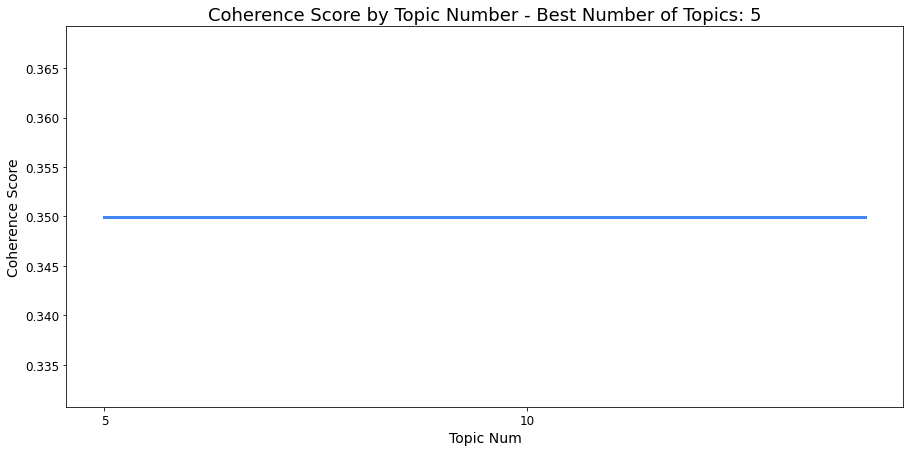

In [297]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

#Create a dictionary
dictionary = Dictionary(docs_clean)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in docs_clean]



# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5,15, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        random_state=10
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=docs_clean,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)


# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.savefig('coherenceNMF.png')
plt.show()


In [312]:

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stopwords,
    max_df=0.8,
    ngram_range=(1, 2),
   )


tfidf = tfidf_vectorizer.fit_transform(docs)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=10,
    max_iter=500,
    solver='cd',
    random_state=10
).fit(tfidf)


# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(docs))

n_top_words = 8
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topics)

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words = 8  
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
#topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
#topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,0,1,2,3,4,5,6,7,topics
0,home,walk,neighborhood,enjoy,quiet,area,helpful,minute,home walk neighborhood enjoy quiet area helpfu...
1,host,friendly,friendly host,clean host,responsive,helpful,excellent host,host clean,host friendly friendly host clean host respons...
2,clean,clean host,clean comfortable,apartment clean,clean quiet,host clean,clean spacious,quiet,clean clean host clean comfortable apartment c...
3,apartment,apartment clean,clean apartment,host apartment,spacious,beautiful apartment,beautiful,apartment spacious,apartment apartment clean clean apartment host...
4,comfortable,clean comfortable,bed,comfortable clean,comfortable bed,bed comfortable,comfortable apartment,spacious comfortable,comfortable clean comfortable bed comfortable ...


In [470]:
topic_df['topics'].to_csv('topicNMF.csv')

# TFIDF / SVD( LSA)

In [198]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.7) 
topic_modeler4 = TruncatedSVD(5, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler4);

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, FRIENDLY, HIGHLY 

Topic 1:
 HOST, FRIENDLY HOST, HOST HIGHLY, EXCELLENT HOST, HELPFUL HOST, AMAZE HOST, RESPONSIVE HOST, HOST RESPONSIVE, HOST HELPFUL, CLEAN HOST 

Topic 2:
 CLEAN, HOST, CLEAN COMFORTABLE, CLEAN HOST, HOST CLEAN, CLEAN QUIET, COMFORTABLE CLEAN, CLEAN CONVENIENT, CLEAN COZY, CLEAN SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT SPACIOUS, SPACIOUS APARTMENT, EXCELLENT 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, APARTMENT, HIGHLY, SPACE, BED, HOME, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN 



In [200]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  
topic_modeler4 = TruncatedSVD(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler4);#this is promising 

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, WALK, NEIGHBORHOOD 

Topic 1:
 HOST, FRIENDLY, RESPONSIVE, HELPFUL, EXCELLENT, ACCOMMODATE, KIND, AMAZE, GRACIOUS, HIGHLY 

Topic 2:
 CLEAN, COMFORTABLE, COZY, SPACIOUS, STYLISH, QUIET, COMMUNICATION, SPARKLE, SPACE, PRIVATE 

Topic 3:
 APARTMENT, CLEAN, SPACIOUS, RESPONSIVE, HOST, EXCELLENT, FANTASTIC, EQUIP, EXACTLY, BUILDING 

Topic 4:
 CLOSE, SUBWAY, CLEAN, RESTAURANT, EASY, WALK, CONVENIENT, HOST, TRAIN, MINUTE 



In [197]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8) 
topic_modeler5 = TruncatedSVD(6, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler5);

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, FRIENDLY, HIGHLY 

Topic 1:
 HOST, FRIENDLY HOST, HOST HIGHLY, EXCELLENT HOST, HELPFUL HOST, AMAZE HOST, RESPONSIVE HOST, HOST RESPONSIVE, HOST HELPFUL, CLEAN HOST 

Topic 2:
 CLEAN, HOST, CLEAN COMFORTABLE, CLEAN HOST, HOST CLEAN, CLEAN QUIET, COMFORTABLE CLEAN, CLEAN CONVENIENT, CLEAN COZY, CLEAN SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, SPACIOUS APARTMENT, APARTMENT SPACIOUS, APARTMENT CLOSE 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, HIGHLY, APARTMENT, BED, SPACE, HOME, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN 

Topic 5:
 HIGHLY, BEAUTIFUL, AMAZE, HOME, EXPERIENCE, SPACE, EASY, COMMUNICATION, HOST HIGHLY, QUICK 



# TFIDF / LatentDirichletAllocation

In [209]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler6 = LatentDirichletAllocation(n_components=20, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler6);

Topic 0:
 SPACE, CLEAN, HOST, APARTMENT, COMFORTABLE, WALK, CLOSE, EASY, SUBWAY, NEIGHBORHOOD 

Topic 1:
 APARTMENT, CLEAN, HOST, SUBWAY, EASY, WALK, CLOSE, COMFORTABLE, SPACE, NEIGHBORHOOD 

Topic 2:
 COMFORTABLE, CLEAN, HOST, APARTMENT, EASY, SUBWAY, CLOSE, NEIGHBORHOOD, SPACE, HOME 

Topic 3:
 APARTMENT, CLEAN, HOST, SUBWAY, CLOSE, EASY, COMFORTABLE, NEIGHBORHOOD, WALK, SPACE 

Topic 4:
 HOST, APARTMENT, CLEAN, CLOSE, SUBWAY, SPACE, WALK, COMFORTABLE, BED, EASY 

Topic 5:
 WALK, SUBWAY, CLEAN, EASY, HOST, CLOSE, COMFORTABLE, APARTMENT, NEIGHBORHOOD, HOME 

Topic 6:
 SPACE, EASY, WALK, COMFORTABLE, SUBWAY, APARTMENT, NEIGHBORHOOD, HOST, BED, CLEAN 

Topic 7:
 EASY, CLEAN, HOST, APARTMENT, SUBWAY, WALK, COMFORTABLE, CLOSE, SPACE, NEIGHBORHOOD 

Topic 8:
 HOST, APARTMENT, CLEAN, CLOSE, SUBWAY, WALK, BED, NEIGHBORHOOD, EASY, COMFORTABLE 

Topic 9:
 CLEAN, HOST, APARTMENT, SUBWAY, WALK, CLOSE, BED, EASY, NEIGHBORHOOD, COMFORTABLE 

Topic 10:
 NEIGHBORHOOD, HOST, CLEAN, APARTMENT, WALK, C

In [303]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler7 = LatentDirichletAllocation(n_components=10, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler7,10);

Topic 0:
 SPACE, CLEAN, COMFORTABLE, HOST, WALK, APARTMENT, BED, HOME, EASY, SUBWAY 

Topic 1:
 APARTMENT, CLEAN, HOST, WALK, SUBWAY, COMFORTABLE, EASY, CLOSE, BED, HOME 

Topic 2:
 COMFORTABLE, BED, CLEAN, APARTMENT, HOST, WALK, SUBWAY, EASY, HOME, CLOSE 

Topic 3:
 RESTAURANT, APARTMENT, SUBWAY, WALK, CLOSE, HOST, CLEAN, COMFORTABLE, HOME, EASY 

Topic 4:
 HOST, CLEAN, APARTMENT, WALK, COMFORTABLE, HOME, EASY, SUBWAY, BED, NEIGHBORHOOD 

Topic 5:
 SUBWAY, CLOSE, WALK, CLEAN, HOST, APARTMENT, COMFORTABLE, EASY, BED, HOME 

Topic 6:
 NEIGHBORHOOD, WALK, APARTMENT, HOST, SUBWAY, CLEAN, COMFORTABLE, HOME, CLOSE, EASY 

Topic 7:
 EASY, WALK, CLEAN, HOST, SUBWAY, APARTMENT, COMFORTABLE, HOME, RESTAURANT, CLOSE 

Topic 8:
 CLOSE, HOST, CLEAN, SUBWAY, APARTMENT, HOME, WALK, COMFORTABLE, EASY, BED 

Topic 9:
 CLEAN, HOME, HOST, COMFORTABLE, WALK, APARTMENT, SUBWAY, CLOSE, EASY, BED 



In [222]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  
topic_modeler8 = LatentDirichletAllocation(n_components=5,random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler8);

Topic 0:
 SPACE, BED, COMFORTABLE, CLEAN, WALK, HOST, HOME, NEIGHBORHOOD, APARTMENT, RESTAURANT 

Topic 1:
 APARTMENT, CLEAN, WALK, HOST, EASY, RESTAURANT, NEIGHBORHOOD, SUBWAY, CLOSE, COMFORTABLE 

Topic 2:
 EASY, COMFORTABLE, CLOSE, CLEAN, SUBWAY, BED, WALK, APARTMENT, NEIGHBORHOOD, HOST 

Topic 3:
 SUBWAY, HOME, WALK, RESTAURANT, CLOSE, CLEAN, APARTMENT, HOST, COMFORTABLE, NEIGHBORHOOD 

Topic 4:
 HOST, NEIGHBORHOOD, CLEAN, WALK, SUBWAY, EASY, COMFORTABLE, CLOSE, APARTMENT, HOME 



In [327]:
# for TFIDF DTM
dtm_tfidf = vectorizer2.fit_transform(docs)


lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=10)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=10)

In [316]:
#p= 
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, vectorizer2)
#pyLDAvis.save_html(p, 'lda.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.100839 -0.128571       1        1  14.196239
8     -0.395685  0.126510       2        1  11.655602
9     -0.249926  0.011435       3        1  10.580907
2      0.064107 -0.182828       4        1  10.310782
3      0.068102 -0.120030       5        1   9.859397
1      0.100778  0.223661       6        1   9.639859
6      0.018136 -0.179280       7        1   9.082443
0      0.074892 -0.012859       8        1   8.611568
4      0.010356 -0.064918       9        1   8.334948
5      0.208402  0.326880      10        1   7.728254, topic_info=            Term         Freq        Total Category  logprob  loglift
4    comfortable  4868.000000  4868.000000  Default  13.0000  13.0000
5           easy  3950.000000  3950.000000  Default  12.0000  12.0000
8   neighborhood  3192.000000  3192.000000  Default  11.0000  11.0000
7           host  7155.000000  7155.000000  Default  10.0000  10.0000
1            bed  2720.000000  2720.000000  Default   9.0000   9.0000
..           ...          ...          ...      ...      ...      ...
8   neighborhood     0.123167  3192.358493  Topic10 -10.4386  -7.6024
12          walk     0.123169  3213.109664  Topic10 -10.4386  -7.6089
3          close     0.123171  3368.454494  Topic10 -10.4386  -7.6561
11        subway     0.123174  3718.139544  Topic10 -10.4386  -7.7548
5           easy     0.123170  3950.435166  Topic10 -10.4386  -7.8155

[143 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.498306  apartment
0         2  0.000157  apartment
0         4  0.083733  apartment
0         5  0.080743  apartment
0         6  0.071142  apartment
...     ...       ...        ...
11        6  0.030660     subway
11        7  0.091444     subway
11        9  0.044646     subway
12        4  0.844042       walk
12        5  0.155612       walk

[62 rows x 3 columns], R=13, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 10, 3, 4, 2, 7, 1, 5, 6])

In [315]:
# Create a dictionary
dictionary = Dictionary(docs_clean)
dictionary.filter_extremes(no_below=3, no_above=0.8)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(text) for text in docs_clean]


In [301]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

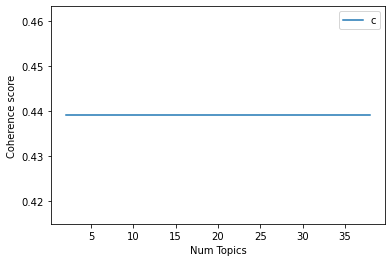

In [302]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs_clean, 
                                                        start=2, limit=40, step=6)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()